# Required Imports
 Note that we are using numpy, cv2, and matplotlib.pyplot for computations, image processing, and data visualization, respectively.

In [1]:
import os
import math
import numpy as np
import time
import cv2
import matplotlib.pyplot as plt
from PIL import Image

seed = 1234
np.random.seed(seed)

# Retrieving images
Here, we open a few images from our dataset and load them as numpy objects. Then we display the images to show what our dataset is like.

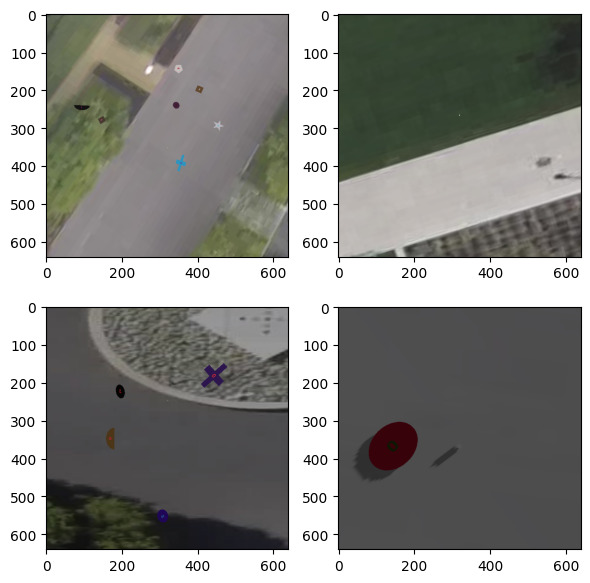

In [2]:
# Example of input images

image1 = np.asarray(Image.open('/kaggle/input/forge-4000/4000_all_labels/train/images/0.png'))
image2 = np.asarray(Image.open('/kaggle/input/forge-4000/4000_all_labels/train/images/10.png'))
image3 = np.asarray(Image.open('/kaggle/input/forge-4000/4000_all_labels/train/images/100.png'))
image4 = np.asarray(Image.open('/kaggle/input/forge-4000/4000_all_labels/train/images/1000.png'))

fig, axis = plt.subplots(2, 2, figsize=(6, 6))
axis[0][0].imshow(image1)
axis[0][1].imshow(image2)
axis[1][0].imshow(image3)
axis[1][1].imshow(image4)

plt.tight_layout()
plt.show()

Print the shape of the image to understand the dimensions of the image.

In [3]:
print(image1.shape)

(640, 640, 3)


# Image file paths

Obtain the file paths of the images in the dataset and store them in an array.

In [4]:
train_images_folder = '/kaggle/input/forge-4000/4000_all_labels/train/images'
train_images = [os.path.join(root, filename) for root, dirs, files in os.walk(train_images_folder) for filename in files]
print('train size: '+str(len(train_images)))

train_labels_folder = '/kaggle/input/forge-4000/4000_all_labels/train/labels'
train_labels = [os.path.join(root, filename) for root, dirs, files in os.walk(train_labels_folder) for filename in files]

valid_images_folder = '/kaggle/input/forge-4000/4000_all_labels/valid/images'
valid_images = [os.path.join(root, filename) for root, dirs, files in os.walk(valid_images_folder) for filename in files]
print('valid size: '+str(len(valid_images)))

valid_labels_folder = '/kaggle/input/forge-4000/4000_all_labels/valid/labels'
valid_labels = [os.path.join(root, filename) for root, dirs, files in os.walk(valid_labels_folder) for filename in files]

test_images_folder = '/kaggle/input/forge-4000/4000_all_labels/test/images'
test_images = [os.path.join(root, filename) for root, dirs, files in os.walk(test_images_folder) for filename in files]
print('test size: '+str(len(test_images)))

test_labels_folder = '/kaggle/input/forge-4000/4000_all_labels/test/labels'
test_labels = [os.path.join(root, filename) for root, dirs, files in os.walk(test_labels_folder) for filename in files]

train size: 2800
valid size: 800
test size: 400


# Example Image with Labels
This code first loads an image and its labels, calculates the bounding boxes, draws the bounding boxes on the image, then displays the result.

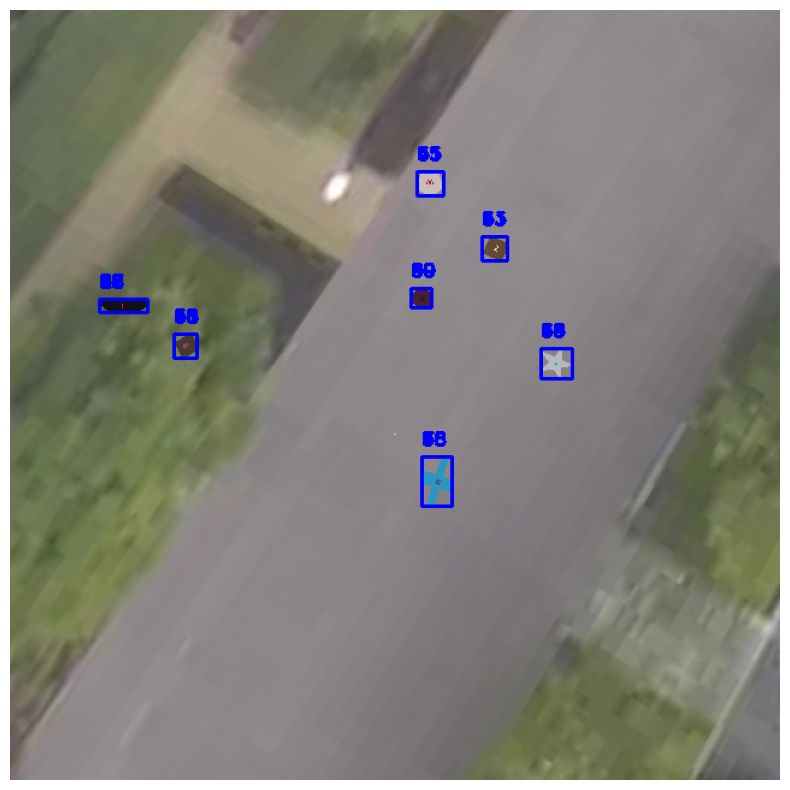

In [5]:
# Load image
image_path = '/kaggle/input/forge-4000/4000_all_labels/train/images/0.png'
image = cv2.imread(image_path)
image_height, image_width = image.shape[:2]

# Read labels.txt file
labels_path = '/kaggle/input/forge-4000/4000_all_labels/train/labels/0.txt'
bounding_boxes = []

with open(labels_path, 'r') as file:
    for line in file:
        parts = line.strip().split()
        label = int(parts[0])
        x_center, y_center, width, height = map(float, parts[1:])
        
        # Convert normalized coordinates to pixel values
        x_center = int(x_center * image_width)
        y_center = int(y_center * image_height)
        width = int(width * image_width)
        height = int(height * image_height)
        
        # Calculate top-left corner of bounding box
        x_min = int(x_center - width / 2)
        y_min = int(y_center - height / 2)
        
        # Store bounding box with label
        bounding_boxes.append((label, x_min, y_min, width, height))

# Draw bounding boxes on image
for label, x_min, y_min, width, height in bounding_boxes:
    # Draw rectangle (bounding box)
    cv2.rectangle(image, (x_min, y_min), (x_min + width, y_min + height), (255, 0, 0), 2)
    # Put label above the bounding box
    cv2.putText(image, str(label), (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

# Display the image with bounding boxes
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Import PyTorch Libraries
PyTorch provides efficient tools for handling large datasets through Dataset and DataLoader classes.

In [6]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from torchvision import tv_tensors

# Torch Dataset Class

Here, we create a custom dataset class that inherits from the torch.utils.data.Dataset class. This class will be used to load the images and their corresponding labels.

In [7]:
class ForgeDataset(Dataset):
    def __init__(self, images_folder, labels_folder, transform=None):
        self.images_folder = images_folder
        self.labels_folder = labels_folder
        self.transform = transform
        
        # List all images and labels
        self.image_files = sorted([os.path.join(root, filename) 
                                   for root, _, files in os.walk(images_folder) 
                                   for filename in files if filename.endswith('.png')])
        
        self.label_files = sorted([os.path.join(root, filename) 
                                   for root, _, files in os.walk(labels_folder) 
                                   for filename in files if filename.endswith('.txt')])
        
        # Sanity check to ensure the dataset is matched properly
        assert len(self.image_files) == len(self.label_files), "Number of images and labels do not match."

    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load image
        image_path = self.image_files[idx]
        image = Image.open(image_path).convert("RGB")
        
        # Load label
        label_path = self.label_files[idx]
        boxes = []
        with open(label_path, 'r') as f:
            for line in f.readlines():
                # Each line: class_id, x, y, width, height
                values = line.strip().split()
                if len(values) != 5:  # Check for well-formed lines
                    continue
                class_id = int(values[0])
                x_center = float(values[1])
                y_center = float(values[2])
                width = float(values[3])
                height = float(values[4])
                
                # Add box as a tuple (class_id, x_center, y_center, width, height)
                boxes.append([class_id, x_center, y_center, width, height])
        
        # Convert boxes to tensor
        boxes = torch.tensor(boxes, dtype=torch.float32)
        if len(boxes) > 50:
            boxes = boxes[:50]  # Truncate if more than max_boxes
        elif len(boxes) < 50:
            # Pad with -1 for consistency
            padding = torch.full((50 - len(boxes), 5), -1, dtype=torch.float32)
            boxes = torch.cat([boxes, padding], dim=0)
        
        # Apply any image transformations (if provided)
        if self.transform:
            image = self.transform(image)
        
        return image, boxes

# Transformations
Here, we are running transformations and testing it on one image for data augmentation. The goal here is to artificially create more data out of existing data to train out model with. The output here is the original image.

https://pytorch.org/vision/main/transforms.html

In [8]:
# Transformations
H, W = 640,640
# img = np.asarray(Image.open('/kaggle/input/forge-4000/4000_all_labels/train/images/0.png'))
img = Image.open('/kaggle/input/forge-4000/4000_all_labels/train/images/0.png')


# boxes = torch.randint(0, H // 2, size=(3, 4))
# boxes[:, 2:] += boxes[:, :2]
# boxes = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=(H, W))

# transform = v2.Compose([
#     v2.ToImage(), 
#     v2.ToDtype(torch.float32, scale=True),  # Convert images to PyTorch tensors
#     v2.RandomHorizontalFlip(p=0.5),
#     v2.RandomVerticalFlip(p=0.5),
#     v2.RandomRotation(degrees=(0, 360)),
#     v2.RandomGrayscale(p=1),
#     v2.RandomInvert(p=0.5),
#     v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

import torchvision.transforms as transforms
transform = transforms.Compose([
    transforms.RandomApply([transforms.ColorJitter(contrast=0.5)], p=1),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.5)], p=1),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=(21, 21))], p=1),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # Normalize the image
])

# pil_image = v2.ToPILImage()(img)
# plt.imshow(pil_image)
# plt.show()

# Displaying transformed image
We run the transformation function on our test image and show the resulting output.

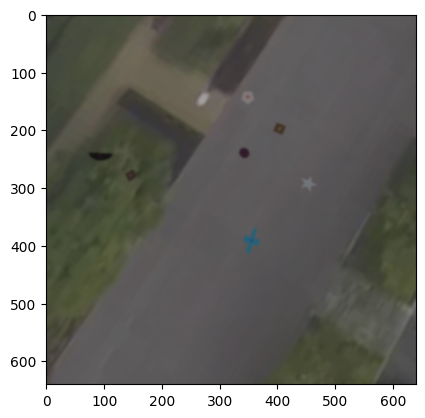

In [9]:
transformed_img = transform(img)
# pil_image = v2.ToPILImage()(transformed_img)
pil_image = np.moveaxis(transformed_img.cpu().numpy(), 0, -1) * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
plt.imshow(pil_image)
plt.show()

# Create DataLoader


In [10]:
# Paths to the folders
train_images_folder = '/kaggle/input/forge-4000/4000_all_labels/train/images'
train_labels_folder = '/kaggle/input/forge-4000/4000_all_labels/train/labels'

# Initialize Dataset
train_dataset = ForgeDataset(images_folder=train_images_folder, labels_folder=train_labels_folder, transform=transform)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)

print(len(train_loader))
# number of batches (images/batch_size)

700


In [11]:
# Paths to the folders
valid_images_folder = '/kaggle/input/forge-4000/4000_all_labels/valid/images'
valid_labels_folder = '/kaggle/input/forge-4000/4000_all_labels/valid/labels'

# Initialize Dataset
valid_dataset = ForgeDataset(images_folder=valid_images_folder, labels_folder=valid_labels_folder, transform=transform)

# Create DataLoader
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=True, num_workers=4)

print(len(valid_loader))
# number of batches (images/batch_size)

200


# Load the YOLOv5 pretrained model

https://docs.ultralytics.com/yolov5/tutorials/pytorch_hub_model_loading/#simple-example

In [12]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', autoshape=False, classes=61)

/opt/conda/lib/python3.10/site-packages/torch/hub.py:295: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.3/886.3 kB 21.0 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


YOLOv5 🚀 2024-11-14 Python-3.10.14 torch-2.4.0+cpu CPU

Overriding model.yaml nc=80 with nc=61

                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Conv                      [3, 32, 6, 2, 2]              
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     18816  models.common.C3                        [64, 64, 1]                   
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  2    115712  models.common.C3                        [128, 128, 2]                 
  5                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  6                -1  3    625152  models.common.C3                        [256, 256, 3]                 
  7                -1  1   1180672  models.commo

# Run YoloV5 model on images
Since the UAV Forge team is using a Yolo model, we plan to run a YOLOv5 for a benchmark and a comparison to our results.

In [13]:
from ultralytics import YOLO

In [14]:
# # Load a model
# model = YOLO("yolov5n.pt")

# # Train the model
# train_results = model.train(
#     data="/kaggle/input/forge-4000/4000_all_labels/data-kaggle.yaml",  # path to dataset YAML
#     epochs=3,  # number of training epochs
#     imgsz=640,  # training image size
# )

# model.save('/kaggle/working/new-model.pt')

In [15]:
model = YOLO("/kaggle/input/forge-v1/pytorch/default/1/new-model.pt")


0: 640x640 2 circles, 1 semicircle, 2 rectangles, 1 pentagon, 2 stars, 1 cross, 205.1ms
Speed: 4.1ms preprocess, 205.1ms inference, 15.7ms postprocess per image at shape (1, 3, 640, 640)


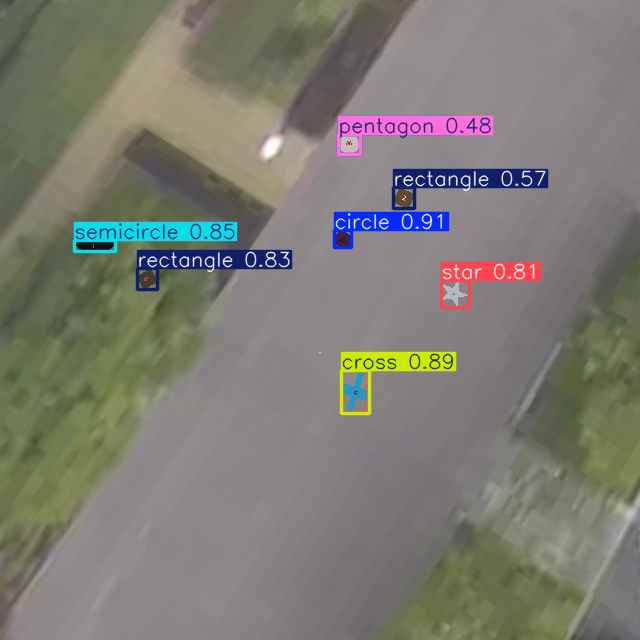

In [16]:
results = model(img)

results[0].show()

In [17]:
print(results[0].boxes.xywhn)
print(results[0].boxes.cls)
print(results[0].boxes.conf)

tensor([[0.53590, 0.37392, 0.02760, 0.02622],
        [0.55531, 0.61209, 0.04258, 0.06705],
        [0.14863, 0.38425, 0.06415, 0.01809],
        [0.23074, 0.43546, 0.03134, 0.03243],
        [0.71152, 0.45968, 0.04450, 0.04179],
        [0.63139, 0.30931, 0.03401, 0.03256],
        [0.54615, 0.22588, 0.03428, 0.03243],
        [0.55464, 0.61159, 0.04314, 0.06669],
        [0.54618, 0.22571, 0.03363, 0.03192]])
tensor([0., 7., 1., 4., 6., 4., 5., 6., 0.])
tensor([0.91029, 0.89251, 0.84861, 0.83079, 0.80938, 0.57221, 0.48367, 0.44260, 0.25883])


In [18]:
import os
import torch
from PIL import Image
import numpy as np
from tqdm import tqdm

def load_labels(label_path):
    with open(label_path, 'r') as f:
        lines = f.readlines()
    labels = [list(map(float, line.strip().split())) for line in lines]
    return torch.tensor(labels)

def calculate_iou(box1, box2):
    # Convert YOLO format to [x1, y1, x2, y2]
    b1_x1, b1_y1 = box1[0] - box1[2] / 2, box1[1] - box1[3] / 2
    b1_x2, b1_y2 = box1[0] + box1[2] / 2, box1[1] + box1[3] / 2
    b2_x1, b2_y1 = box2[0] - box2[2] / 2, box2[1] - box2[3] / 2
    b2_x2, b2_y2 = box2[0] + box2[2] / 2, box2[1] + box2[3] / 2

    # Intersection rectangle
    inter_rect_x1 = max(b1_x1, b2_x1)
    inter_rect_y1 = max(b1_y1, b2_y1)
    inter_rect_x2 = min(b1_x2, b2_x2)
    inter_rect_y2 = min(b1_y2, b2_y2)

    # Intersection area
    inter_area = max(inter_rect_x2 - inter_rect_x1, 0) * max(inter_rect_y2 - inter_rect_y1, 0)

    # Union Area
    b1_area = (b1_x2 - b1_x1) * (b1_y2 - b1_y1)
    b2_area = (b2_x2 - b2_x1) * (b2_y2 - b2_y1)

    iou = inter_area / float(b1_area + b2_area - inter_area)
    return iou

def calculate_accuracy(model, valid_images_folder, valid_labels_folder, iou_threshold=0.5, conf_threshold=0.5):
    image_files = os.listdir(valid_images_folder)
    total_correct = 0
    total_predictions = 0

    for image_file in tqdm(image_files):
        image_path = os.path.join(valid_images_folder, image_file)
        label_path = os.path.join(valid_labels_folder, image_file.replace('.png', '.txt'))

        # Load image and run model
        img = Image.open(image_path)
        results = model(img)

        # Get predictions
        pred_boxes = results[0].boxes.xywhn
        pred_classes = results[0].boxes.cls
        pred_conf = results[0].boxes.conf

        # Load ground truth labels
        gt_labels = load_labels(label_path)

        # Compare predictions with ground truth
        for pred_box, pred_class, conf in zip(pred_boxes, pred_classes, pred_conf):
            if conf < conf_threshold:
                continue

            total_predictions += 1
            for gt_label in gt_labels:
                gt_class, gt_box = gt_label[0], gt_label[1:]
                iou = calculate_iou(pred_box, gt_box)

                if iou >= iou_threshold and pred_class == gt_class:
                    total_correct += 1
                    break

    accuracy = total_correct / total_predictions if total_predictions > 0 else 0
    return accuracy

# Usage
valid_images_folder = '/kaggle/input/forge-4000/4000_all_labels/valid/images'
valid_labels_folder = '/kaggle/input/forge-4000/4000_all_labels/valid/labels'

accuracy = calculate_accuracy(model, valid_images_folder, valid_labels_folder)
print(f"Validation Accuracy: {accuracy:.4f}")

  0%|          | 0/800 [00:00<?, ?it/s]


0: 640x640 1 star, 1 cross, 145.9ms
Speed: 4.0ms preprocess, 145.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 1/800 [00:00<02:30,  5.30it/s]


0: 640x640 2 circles, 1 rectangle, 2 crosss, 145.8ms
Speed: 3.0ms preprocess, 145.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 2/800 [00:00<02:40,  4.97it/s]


0: 640x640 1 circle, 1 quartercircle, 3 stars, 139.6ms
Speed: 2.2ms preprocess, 139.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 3/800 [00:00<02:45,  4.82it/s]


0: 640x640 1 pentagon, 2 stars, 2 crosss, 133.5ms
Speed: 2.1ms preprocess, 133.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 4/800 [00:00<02:37,  5.06it/s]


0: 640x640 3 circles, 1 semicircle, 1 rectangle, 1 pentagon, 1 star, 2 crosss, 145.5ms
Speed: 2.4ms preprocess, 145.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 5/800 [00:01<02:44,  4.84it/s]


0: 640x640 1 quartercircle, 1 rectangle, 1 pentagon, 1 star, 1 cross, 1 shape:black, 1 shape:purple, 1 shape:brown, 1 char:white, 132.0ms
Speed: 2.2ms preprocess, 132.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 6/800 [00:01<02:40,  4.95it/s]


0: 640x640 1 circle, 2 triangles, 3 rectangles, 1 cross, 1 char:brown, 139.0ms
Speed: 2.1ms preprocess, 139.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 7/800 [00:01<02:40,  4.94it/s]


0: 640x640 (no detections), 142.6ms
Speed: 2.2ms preprocess, 142.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 8/800 [00:01<02:36,  5.07it/s]


0: 640x640 1 quartercircle, 2 triangles, 2 rectangles, 145.7ms
Speed: 2.1ms preprocess, 145.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 9/800 [00:01<02:35,  5.09it/s]


0: 640x640 (no detections), 136.7ms
Speed: 2.0ms preprocess, 136.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


  1%|▏         | 10/800 [00:01<02:29,  5.27it/s]


0: 640x640 1 semicircle, 1 quartercircle, 1 shape:purple, 134.7ms
Speed: 1.9ms preprocess, 134.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  1%|▏         | 11/800 [00:02<02:27,  5.37it/s]


0: 640x640 3 circles, 3 semicircles, 1 quartercircle, 1 cross, 135.3ms
Speed: 2.2ms preprocess, 135.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 12/800 [00:02<02:30,  5.23it/s]


0: 640x640 1 quartercircle, 136.6ms
Speed: 2.0ms preprocess, 136.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 13/800 [00:02<02:26,  5.39it/s]


0: 640x640 1 circle, 3 semicircles, 2 quartercircles, 1 rectangle, 2 pentagons, 1 star, 134.9ms
Speed: 1.9ms preprocess, 134.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 14/800 [00:02<02:29,  5.26it/s]


0: 640x640 1 circle, 1 semicircle, 1 quartercircle, 1 triangle, 1 rectangle, 2 pentagons, 1 star, 3 crosss, 138.2ms
Speed: 2.0ms preprocess, 138.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 15/800 [00:02<02:43,  4.81it/s]


0: 640x640 1 semicircle, 1 quartercircle, 1 triangle, 1 rectangle, 2 pentagons, 3 crosss, 1 shape:white, 1 shape:blue, 1 shape:orange, 1 char:purple, 137.8ms
Speed: 2.0ms preprocess, 137.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 16/800 [00:03<02:43,  4.80it/s]


0: 640x640 (no detections), 138.3ms
Speed: 2.1ms preprocess, 138.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 17/800 [00:03<02:33,  5.09it/s]


0: 640x640 2 circles, 1 quartercircle, 1 pentagon, 1 shape:black, 135.2ms
Speed: 2.0ms preprocess, 135.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 18/800 [00:03<02:32,  5.13it/s]


0: 640x640 2 semicircles, 5 rectangles, 3 pentagons, 1 cross, 127.4ms
Speed: 2.0ms preprocess, 127.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 19/800 [00:03<02:33,  5.08it/s]


0: 640x640 1 triangle, 1 rectangle, 1 pentagon, 129.7ms
Speed: 2.0ms preprocess, 129.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


  2%|▎         | 20/800 [00:03<02:27,  5.28it/s]


0: 640x640 1 triangle, 2 rectangles, 2 stars, 2 crosss, 1 shape:green, 1 shape:brown, 138.4ms
Speed: 2.0ms preprocess, 138.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 21/800 [00:04<02:30,  5.18it/s]


0: 640x640 (no detections), 132.5ms
Speed: 2.1ms preprocess, 132.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 22/800 [00:04<02:25,  5.34it/s]


0: 640x640 1 circle, 4 rectangles, 1 pentagon, 2 stars, 1 char:white, 130.5ms
Speed: 2.1ms preprocess, 130.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 23/800 [00:04<02:27,  5.27it/s]


0: 640x640 1 circle, 1 semicircle, 1 star, 1 cross, 1 shape:green, 1 char:red, 127.5ms
Speed: 2.1ms preprocess, 127.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 24/800 [00:04<02:24,  5.37it/s]


0: 640x640 (no detections), 130.5ms
Speed: 2.0ms preprocess, 130.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 25/800 [00:04<02:21,  5.47it/s]


0: 640x640 3 stars, 4 crosss, 1 shape:white, 130.2ms
Speed: 2.2ms preprocess, 130.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 26/800 [00:05<02:26,  5.28it/s]


0: 640x640 1 circle, 1 semicircle, 1 triangle, 1 star, 1 cross, 1 shape:brown, 1 char:white, 1 char:black, 1 char:blue, 138.0ms
Speed: 2.0ms preprocess, 138.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 27/800 [00:05<02:26,  5.27it/s]


0: 640x640 1 circle, 2 semicircles, 1 quartercircle, 1 rectangle, 1 star, 1 char:white, 1 char:black, 136.1ms
Speed: 2.0ms preprocess, 136.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  4%|▎         | 28/800 [00:05<02:28,  5.21it/s]


0: 640x640 1 semicircle, 1 triangle, 139.6ms
Speed: 2.0ms preprocess, 139.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


  4%|▎         | 29/800 [00:05<02:28,  5.18it/s]


0: 640x640 1 semicircle, 1 quartercircle, 3 rectangles, 3 pentagons, 1 cross, 1 shape:black, 136.0ms
Speed: 2.0ms preprocess, 136.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


  4%|▍         | 30/800 [00:05<02:33,  5.03it/s]


0: 640x640 1 circle, 1 semicircle, 136.6ms
Speed: 2.0ms preprocess, 136.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  4%|▍         | 31/800 [00:06<02:29,  5.16it/s]


0: 640x640 1 triangle, 139.6ms
Speed: 2.0ms preprocess, 139.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


  4%|▍         | 32/800 [00:06<02:25,  5.29it/s]


0: 640x640 2 circles, 1 semicircle, 1 quartercircle, 2 triangles, 1 pentagon, 2 crosss, 136.3ms
Speed: 2.0ms preprocess, 136.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  4%|▍         | 33/800 [00:06<02:31,  5.07it/s]


0: 640x640 (no detections), 133.8ms
Speed: 2.2ms preprocess, 133.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


  4%|▍         | 34/800 [00:06<02:23,  5.33it/s]


0: 640x640 (no detections), 133.8ms
Speed: 2.0ms preprocess, 133.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


  4%|▍         | 35/800 [00:06<02:20,  5.45it/s]


0: 640x640 (no detections), 137.3ms
Speed: 2.0ms preprocess, 137.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


  4%|▍         | 36/800 [00:06<02:18,  5.51it/s]


0: 640x640 1 circle, 1 semicircle, 1 triangle, 2 rectangles, 1 pentagon, 1 cross, 139.1ms
Speed: 2.0ms preprocess, 139.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  5%|▍         | 37/800 [00:07<02:26,  5.21it/s]


0: 640x640 1 circle, 1 quartercircle, 2 triangles, 1 pentagon, 3 stars, 1 cross, 139.0ms
Speed: 2.2ms preprocess, 139.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  5%|▍         | 38/800 [00:07<02:27,  5.18it/s]


0: 640x640 1 semicircle, 1 quartercircle, 1 rectangle, 1 pentagon, 3 stars, 2 crosss, 1 shape:black, 1 shape:blue, 1 char:brown, 1 char:orange, 133.2ms
Speed: 2.3ms preprocess, 133.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


  5%|▍         | 39/800 [00:07<02:28,  5.12it/s]


0: 640x640 1 circle, 1 rectangle, 1 pentagon, 130.3ms
Speed: 2.0ms preprocess, 130.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  5%|▌         | 40/800 [00:07<02:27,  5.14it/s]


0: 640x640 (no detections), 132.5ms
Speed: 2.1ms preprocess, 132.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


  5%|▌         | 41/800 [00:07<02:20,  5.38it/s]


0: 640x640 2 circles, 2 quartercircles, 2 triangles, 1 rectangle, 2 pentagons, 133.0ms
Speed: 2.1ms preprocess, 133.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


  5%|▌         | 42/800 [00:08<02:21,  5.35it/s]


0: 640x640 1 circle, 1 quartercircle, 1 pentagon, 1 star, 1 char:brown, 131.4ms
Speed: 2.1ms preprocess, 131.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


  5%|▌         | 43/800 [00:08<02:19,  5.41it/s]


0: 640x640 1 circle, 1 quartercircle, 1 triangle, 1 shape:black, 1 shape:green, 1 char:brown, 145.8ms
Speed: 2.1ms preprocess, 145.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


  6%|▌         | 44/800 [00:08<02:21,  5.35it/s]


0: 640x640 1 quartercircle, 1 rectangle, 1 pentagon, 1 star, 2 crosss, 135.3ms
Speed: 2.0ms preprocess, 135.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  6%|▌         | 45/800 [00:08<02:20,  5.37it/s]


0: 640x640 1 quartercircle, 1 rectangle, 2 pentagons, 2 crosss, 1 shape:green, 1 char:white, 1 char:brown, 136.4ms
Speed: 2.0ms preprocess, 136.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


  6%|▌         | 46/800 [00:08<02:23,  5.27it/s]


0: 640x640 1 rectangle, 1 pentagon, 129.1ms
Speed: 2.1ms preprocess, 129.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


  6%|▌         | 47/800 [00:09<02:17,  5.46it/s]


0: 640x640 1 circle, 1 semicircle, 2 triangles, 1 rectangle, 137.1ms
Speed: 2.0ms preprocess, 137.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  6%|▌         | 48/800 [00:09<02:18,  5.43it/s]


0: 640x640 1 quartercircle, 1 star, 138.9ms
Speed: 2.1ms preprocess, 138.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  6%|▌         | 49/800 [00:09<02:19,  5.37it/s]


0: 640x640 (no detections), 173.4ms
Speed: 2.0ms preprocess, 173.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


  6%|▋         | 50/800 [00:09<02:24,  5.17it/s]


0: 640x640 (no detections), 137.3ms
Speed: 2.0ms preprocess, 137.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


  6%|▋         | 51/800 [00:09<02:21,  5.29it/s]


0: 640x640 2 semicircles, 2 quartercircles, 1 star, 1 shape:green, 1 shape:purple, 1 shape:brown, 1 char:white, 1 char:orange, 139.9ms
Speed: 2.0ms preprocess, 139.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


  6%|▋         | 52/800 [00:09<02:22,  5.26it/s]


0: 640x640 1 circle, 2 semicircles, 2 triangles, 3 stars, 3 crosss, 136.0ms
Speed: 1.9ms preprocess, 136.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 53/800 [00:10<02:26,  5.11it/s]


0: 640x640 1 star, 1 cross, 139.0ms
Speed: 2.0ms preprocess, 139.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 54/800 [00:10<02:22,  5.24it/s]


0: 640x640 (no detections), 138.8ms
Speed: 2.2ms preprocess, 138.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 55/800 [00:10<02:19,  5.33it/s]


0: 640x640 1 circle, 1 triangle, 1 pentagon, 1 star, 1 cross, 135.3ms
Speed: 2.0ms preprocess, 135.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 56/800 [00:10<02:21,  5.26it/s]


0: 640x640 1 circle, 1 semicircle, 1 quartercircle, 1 star, 1 shape:red, 1 shape:orange, 135.7ms
Speed: 1.9ms preprocess, 135.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 57/800 [00:10<02:17,  5.40it/s]


0: 640x640 1 circle, 1 semicircle, 1 quartercircle, 1 triangle, 2 rectangles, 1 pentagon, 1 star, 2 crosss, 129.0ms
Speed: 2.2ms preprocess, 129.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 58/800 [00:11<02:20,  5.27it/s]


0: 640x640 3 rectangles, 2 crosss, 152.8ms
Speed: 2.0ms preprocess, 152.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 59/800 [00:11<02:24,  5.12it/s]


0: 640x640 1 quartercircle, 154.4ms
Speed: 2.7ms preprocess, 154.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 60/800 [00:11<02:27,  5.02it/s]


0: 640x640 1 circle, 2 triangles, 1 rectangle, 3 pentagons, 1 cross, 138.2ms
Speed: 2.2ms preprocess, 138.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 61/800 [00:11<02:31,  4.87it/s]


0: 640x640 2 circles, 3 triangles, 1 rectangle, 167.0ms
Speed: 2.1ms preprocess, 167.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 62/800 [00:11<02:39,  4.61it/s]


0: 640x640 1 semicircle, 1 quartercircle, 144.2ms
Speed: 2.1ms preprocess, 144.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 63/800 [00:12<02:33,  4.81it/s]


0: 640x640 3 circles, 1 rectangle, 1 pentagon, 3 stars, 2 crosss, 1 char:black, 137.7ms
Speed: 2.0ms preprocess, 137.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 64/800 [00:12<02:34,  4.77it/s]


0: 640x640 2 triangles, 2 rectangles, 2 pentagons, 1 star, 1 shape:white, 141.7ms
Speed: 2.1ms preprocess, 141.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 65/800 [00:12<02:32,  4.82it/s]


0: 640x640 1 circle, 1 semicircle, 1 triangle, 1 star, 138.0ms
Speed: 2.1ms preprocess, 138.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 66/800 [00:12<02:31,  4.84it/s]


0: 640x640 1 circle, 2 rectangles, 1 pentagon, 1 star, 1 cross, 136.1ms
Speed: 2.1ms preprocess, 136.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 67/800 [00:12<02:29,  4.90it/s]


0: 640x640 1 semicircle, 1 cross, 1 shape:black, 1 char:white, 137.6ms
Speed: 2.1ms preprocess, 137.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 68/800 [00:13<02:24,  5.06it/s]


0: 640x640 1 circle, 1 semicircle, 1 star, 141.9ms
Speed: 2.0ms preprocess, 141.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


  9%|▊         | 69/800 [00:13<02:22,  5.13it/s]


0: 640x640 1 rectangle, 1 cross, 130.5ms
Speed: 2.0ms preprocess, 130.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


  9%|▉         | 70/800 [00:13<02:16,  5.37it/s]


0: 640x640 1 triangle, 1 pentagon, 135.5ms
Speed: 2.1ms preprocess, 135.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  9%|▉         | 71/800 [00:13<02:14,  5.43it/s]


0: 640x640 1 circle, 1 semicircle, 1 triangle, 2 rectangles, 1 pentagon, 1 star, 1 cross, 135.5ms
Speed: 2.1ms preprocess, 135.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  9%|▉         | 72/800 [00:13<02:17,  5.30it/s]


0: 640x640 1 triangle, 1 pentagon, 132.0ms
Speed: 2.3ms preprocess, 132.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


  9%|▉         | 73/800 [00:14<02:13,  5.45it/s]


0: 640x640 1 circle, 2 triangles, 4 rectangles, 129.2ms
Speed: 2.1ms preprocess, 129.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  9%|▉         | 74/800 [00:14<02:16,  5.31it/s]


0: 640x640 1 circle, 2 rectangles, 2 pentagons, 1 shape:white, 1 shape:blue, 1 char:purple, 1 char:brown, 1 char:orange, 134.3ms
Speed: 2.1ms preprocess, 134.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  9%|▉         | 75/800 [00:14<02:16,  5.31it/s]


0: 640x640 1 semicircle, 1 quartercircle, 1 rectangle, 1 pentagon, 2 stars, 134.5ms
Speed: 2.0ms preprocess, 134.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 10%|▉         | 76/800 [00:14<02:15,  5.34it/s]


0: 640x640 1 semicircle, 2 rectangles, 2 pentagons, 1 star, 1 cross, 128.3ms
Speed: 2.0ms preprocess, 128.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 10%|▉         | 77/800 [00:14<02:13,  5.42it/s]


0: 640x640 1 circle, 1 triangle, 1 rectangle, 2 pentagons, 1 cross, 1 shape:white, 1 shape:green, 1 char:white, 2 char:browns, 129.1ms
Speed: 1.9ms preprocess, 129.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 10%|▉         | 78/800 [00:15<02:11,  5.47it/s]


0: 640x640 (no detections), 136.2ms
Speed: 2.0ms preprocess, 136.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 10%|▉         | 79/800 [00:15<02:14,  5.36it/s]


0: 640x640 1 triangle, 1 rectangle, 1 cross, 1 shape:green, 1 shape:orange, 1 char:white, 1 char:purple, 137.7ms
Speed: 2.0ms preprocess, 137.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 10%|█         | 80/800 [00:15<02:13,  5.40it/s]


0: 640x640 2 circles, 1 semicircle, 1 quartercircle, 1 rectangle, 1 star, 1 cross, 134.7ms
Speed: 2.0ms preprocess, 134.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 10%|█         | 81/800 [00:15<02:15,  5.31it/s]


0: 640x640 2 semicircles, 1 rectangle, 3 stars, 4 crosss, 135.2ms
Speed: 2.0ms preprocess, 135.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 10%|█         | 82/800 [00:15<02:22,  5.05it/s]


0: 640x640 1 triangle, 2 rectangles, 1 char:brown, 129.7ms
Speed: 2.3ms preprocess, 129.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 10%|█         | 83/800 [00:15<02:18,  5.19it/s]


0: 640x640 1 semicircle, 1 pentagon, 1 star, 1 cross, 1 shape:black, 2 shape:blues, 1 shape:green, 1 shape:brown, 1 char:white, 1 char:brown, 136.1ms
Speed: 2.0ms preprocess, 136.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 10%|█         | 84/800 [00:16<02:18,  5.18it/s]


0: 640x640 3 circles, 1 semicircle, 1 pentagon, 128.8ms
Speed: 2.1ms preprocess, 128.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 11%|█         | 85/800 [00:16<02:19,  5.14it/s]


0: 640x640 1 semicircle, 1 quartercircle, 2 rectangles, 2 pentagons, 1 cross, 1 char:brown, 136.2ms
Speed: 2.0ms preprocess, 136.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 11%|█         | 86/800 [00:16<02:17,  5.21it/s]


0: 640x640 2 quartercircles, 1 triangle, 2 shape:greens, 1 shape:brown, 1 shape:orange, 2 char:purples, 2 char:browns, 133.7ms
Speed: 1.9ms preprocess, 133.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 11%|█         | 87/800 [00:16<02:13,  5.34it/s]


0: 640x640 5 circles, 1 semicircle, 1 pentagon, 1 cross, 134.4ms
Speed: 2.0ms preprocess, 134.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 11%|█         | 88/800 [00:16<02:15,  5.24it/s]


0: 640x640 1 circle, 1 semicircle, 1 shape:orange, 135.9ms
Speed: 2.0ms preprocess, 135.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 11%|█         | 89/800 [00:17<02:12,  5.35it/s]


0: 640x640 1 circle, 1 semicircle, 1 quartercircle, 1 pentagon, 1 shape:black, 1 char:purple, 130.1ms
Speed: 2.1ms preprocess, 130.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 11%|█▏        | 90/800 [00:17<02:08,  5.52it/s]


0: 640x640 1 circle, 1 semicircle, 2 rectangles, 1 pentagon, 127.5ms
Speed: 2.1ms preprocess, 127.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 11%|█▏        | 91/800 [00:17<02:08,  5.50it/s]


0: 640x640 (no detections), 128.2ms
Speed: 2.1ms preprocess, 128.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 92/800 [00:17<02:05,  5.65it/s]


0: 640x640 1 circle, 1 semicircle, 1 triangle, 1 rectangle, 1 star, 1 cross, 135.8ms
Speed: 2.1ms preprocess, 135.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 93/800 [00:17<02:07,  5.55it/s]


0: 640x640 2 circles, 2 semicircles, 2 quartercircles, 1 triangle, 1 pentagon, 1 star, 1 cross, 130.9ms
Speed: 2.0ms preprocess, 130.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 94/800 [00:18<02:11,  5.35it/s]


0: 640x640 2 semicircles, 1 triangle, 1 star, 1 shape:blue, 3 shape:greens, 1 shape:brown, 1 shape:orange, 1 char:white, 1 char:black, 1 char:blue, 2 char:browns, 136.9ms
Speed: 2.1ms preprocess, 136.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 95/800 [00:18<02:13,  5.29it/s]


0: 640x640 2 circles, 1 rectangle, 1 pentagon, 2 stars, 1 cross, 128.8ms
Speed: 2.0ms preprocess, 128.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 96/800 [00:18<02:14,  5.22it/s]


0: 640x640 2 circles, 1 semicircle, 1 quartercircle, 3 triangles, 1 pentagon, 1 star, 135.9ms
Speed: 2.1ms preprocess, 135.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 97/800 [00:18<02:16,  5.16it/s]


0: 640x640 1 semicircle, 130.8ms
Speed: 2.2ms preprocess, 130.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 98/800 [00:18<02:11,  5.33it/s]


0: 640x640 1 circle, 1 semicircle, 1 quartercircle, 3 rectangles, 1 pentagon, 1 star, 2 crosss, 1 shape:white, 1 shape:black, 1 shape:blue, 1 char:brown, 128.4ms
Speed: 2.0ms preprocess, 128.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 99/800 [00:18<02:13,  5.25it/s]


0: 640x640 1 semicircle, 2 quartercircles, 1 triangle, 3 rectangles, 2 pentagons, 1 cross, 1 char:purple, 138.4ms
Speed: 1.9ms preprocess, 138.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▎        | 100/800 [00:19<02:16,  5.11it/s]


0: 640x640 2 circles, 1 semicircle, 1 quartercircle, 1 triangle, 1 rectangle, 1 pentagon, 1 star, 1 cross, 136.1ms
Speed: 2.0ms preprocess, 136.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 101/800 [00:19<02:19,  5.01it/s]


0: 640x640 (no detections), 179.1ms
Speed: 4.4ms preprocess, 179.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 102/800 [00:19<02:24,  4.82it/s]


0: 640x640 1 semicircle, 1 triangle, 4 rectangles, 1 pentagon, 130.5ms
Speed: 2.3ms preprocess, 130.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 103/800 [00:19<02:20,  4.97it/s]


0: 640x640 (no detections), 139.7ms
Speed: 2.1ms preprocess, 139.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 104/800 [00:19<02:14,  5.16it/s]


0: 640x640 2 circles, 1 semicircle, 1 triangle, 2 rectangles, 1 pentagon, 1 cross, 142.0ms
Speed: 2.0ms preprocess, 142.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 105/800 [00:20<02:16,  5.08it/s]


0: 640x640 1 circle, 1 rectangle, 1 pentagon, 3 stars, 2 crosss, 137.1ms
Speed: 2.1ms preprocess, 137.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 106/800 [00:20<02:17,  5.05it/s]


0: 640x640 1 semicircle, 1 quartercircle, 1 triangle, 1 pentagon, 2 crosss, 1 shape:black, 1 shape:green, 1 shape:orange, 139.0ms
Speed: 2.1ms preprocess, 139.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 107/800 [00:20<02:16,  5.08it/s]


0: 640x640 1 circle, 2 semicircles, 2 rectangles, 1 star, 2 crosss, 140.8ms
Speed: 2.0ms preprocess, 140.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 14%|█▎        | 108/800 [00:20<02:18,  5.00it/s]


0: 640x640 1 quartercircle, 1 rectangle, 2 pentagons, 1 star, 1 char:purple, 1 char:brown, 129.9ms
Speed: 2.2ms preprocess, 129.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 14%|█▎        | 109/800 [00:20<02:13,  5.18it/s]


0: 640x640 1 quartercircle, 1 triangle, 1 cross, 1 shape:brown, 1 shape:orange, 1 char:purple, 135.6ms
Speed: 2.0ms preprocess, 135.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 14%|█▍        | 110/800 [00:21<02:10,  5.30it/s]


0: 640x640 1 semicircle, 2 quartercircles, 1 rectangle, 2 pentagons, 1 star, 1 cross, 1 shape:black, 1 shape:brown, 1 char:blue, 1 char:brown, 128.8ms
Speed: 2.0ms preprocess, 128.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 14%|█▍        | 111/800 [00:21<02:08,  5.36it/s]


0: 640x640 1 semicircle, 1 quartercircle, 1 rectangle, 1 pentagon, 1 shape:purple, 1 shape:orange, 135.7ms
Speed: 2.0ms preprocess, 135.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 14%|█▍        | 112/800 [00:21<02:06,  5.43it/s]


0: 640x640 1 semicircle, 1 quartercircle, 1 star, 132.2ms
Speed: 2.1ms preprocess, 132.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 14%|█▍        | 113/800 [00:21<02:04,  5.53it/s]


0: 640x640 (no detections), 137.6ms
Speed: 1.9ms preprocess, 137.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 14%|█▍        | 114/800 [00:21<02:03,  5.55it/s]


0: 640x640 2 triangles, 4 rectangles, 2 pentagons, 136.3ms
Speed: 2.0ms preprocess, 136.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 14%|█▍        | 115/800 [00:22<02:05,  5.46it/s]


0: 640x640 1 semicircle, 1 pentagon, 3 stars, 4 crosss, 136.8ms
Speed: 2.0ms preprocess, 136.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 14%|█▍        | 116/800 [00:22<02:05,  5.45it/s]


0: 640x640 1 circle, 3 semicircles, 1 quartercircle, 2 shape:blacks, 1 shape:green, 1 char:purple, 134.8ms
Speed: 2.0ms preprocess, 134.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 15%|█▍        | 117/800 [00:22<02:07,  5.36it/s]


0: 640x640 1 quartercircle, 1 triangle, 141.5ms
Speed: 2.1ms preprocess, 141.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 15%|█▍        | 118/800 [00:22<02:06,  5.39it/s]


0: 640x640 1 semicircle, 1 quartercircle, 138.3ms
Speed: 2.0ms preprocess, 138.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 15%|█▍        | 119/800 [00:22<02:04,  5.48it/s]


0: 640x640 2 circles, 2 semicircles, 1 quartercircle, 1 triangle, 1 shape:green, 131.1ms
Speed: 2.1ms preprocess, 131.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 15%|█▌        | 120/800 [00:22<02:04,  5.46it/s]


0: 640x640 4 circles, 2 semicircles, 1 triangle, 1 star, 2 crosss, 1 shape:white, 134.7ms
Speed: 2.0ms preprocess, 134.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 15%|█▌        | 121/800 [00:23<02:10,  5.22it/s]


0: 640x640 3 circles, 2 semicircles, 1 triangle, 1 star, 2 crosss, 129.0ms
Speed: 1.9ms preprocess, 129.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 15%|█▌        | 122/800 [00:23<02:11,  5.14it/s]


0: 640x640 1 quartercircle, 1 triangle, 2 rectangles, 1 pentagon, 1 star, 2 crosss, 1 shape:blue, 1 shape:orange, 137.3ms
Speed: 2.0ms preprocess, 137.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 15%|█▌        | 123/800 [00:23<02:10,  5.19it/s]


0: 640x640 1 semicircle, 2 quartercircles, 1 rectangle, 2 pentagons, 1 star, 1 shape:green, 134.0ms
Speed: 2.0ms preprocess, 134.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▌        | 124/800 [00:23<02:08,  5.27it/s]


0: 640x640 1 circle, 1 semicircle, 1 rectangle, 1 pentagon, 1 star, 135.9ms
Speed: 2.0ms preprocess, 135.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▌        | 125/800 [00:23<02:06,  5.34it/s]


0: 640x640 (no detections), 128.3ms
Speed: 2.1ms preprocess, 128.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▌        | 126/800 [00:24<02:02,  5.51it/s]


0: 640x640 1 semicircle, 2 triangles, 2 stars, 1 char:black, 134.8ms
Speed: 2.0ms preprocess, 134.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▌        | 127/800 [00:24<02:04,  5.41it/s]


0: 640x640 1 circle, 1 semicircle, 1 quartercircle, 1 rectangle, 1 shape:black, 1 char:purple, 1 char:brown, 129.9ms
Speed: 2.0ms preprocess, 129.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▌        | 128/800 [00:24<02:02,  5.47it/s]


0: 640x640 1 triangle, 1 rectangle, 1 pentagon, 1 cross, 128.7ms
Speed: 1.9ms preprocess, 128.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▌        | 129/800 [00:24<01:59,  5.62it/s]


0: 640x640 1 cross, 126.8ms
Speed: 2.0ms preprocess, 126.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▋        | 130/800 [00:24<01:57,  5.70it/s]


0: 640x640 2 circles, 1 semicircle, 1 triangle, 1 shape:green, 1 shape:brown, 1 shape:orange, 1 char:black, 1 char:blue, 2 char:browns, 135.0ms
Speed: 2.0ms preprocess, 135.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▋        | 131/800 [00:25<01:59,  5.61it/s]


0: 640x640 1 circle, 3 triangles, 4 rectangles, 1 star, 1 cross, 127.1ms
Speed: 2.1ms preprocess, 127.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▋        | 132/800 [00:25<02:02,  5.44it/s]


0: 640x640 1 triangle, 1 cross, 128.0ms
Speed: 2.2ms preprocess, 128.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 133/800 [00:25<01:59,  5.57it/s]


0: 640x640 1 circle, 1 triangle, 1 rectangle, 1 pentagon, 1 shape:black, 1 shape:brown, 1 char:purple, 127.8ms
Speed: 2.1ms preprocess, 127.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 134/800 [00:25<02:00,  5.55it/s]


0: 640x640 1 semicircle, 2 triangles, 1 cross, 1 shape:blue, 1 shape:green, 1 shape:brown, 1 char:black, 1 char:purple, 127.0ms
Speed: 2.0ms preprocess, 127.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 135/800 [00:25<01:59,  5.56it/s]


0: 640x640 1 rectangle, 1 pentagon, 1 shape:blue, 128.5ms
Speed: 2.1ms preprocess, 128.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 136/800 [00:25<01:57,  5.66it/s]


0: 640x640 1 semicircle, 2 rectangles, 2 pentagons, 2 stars, 134.8ms
Speed: 2.1ms preprocess, 134.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 137/800 [00:26<02:02,  5.40it/s]


0: 640x640 1 semicircle, 1 rectangle, 1 pentagon, 1 star, 1 char:brown, 127.6ms
Speed: 2.0ms preprocess, 127.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 138/800 [00:26<02:02,  5.40it/s]


0: 640x640 (no detections), 137.8ms
Speed: 2.0ms preprocess, 137.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 139/800 [00:26<02:02,  5.39it/s]


0: 640x640 1 rectangle, 2 pentagons, 1 star, 2 shape:blues, 1 shape:purple, 2 shape:browns, 1 shape:orange, 1 char:white, 134.7ms
Speed: 2.0ms preprocess, 134.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 140/800 [00:26<02:01,  5.43it/s]


0: 640x640 3 circles, 1 semicircle, 2 pentagons, 1 star, 1 cross, 135.6ms
Speed: 1.9ms preprocess, 135.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 141/800 [00:26<02:03,  5.32it/s]


0: 640x640 3 circles, 1 semicircle, 1 rectangle, 2 pentagons, 133.8ms
Speed: 2.0ms preprocess, 133.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 142/800 [00:27<02:05,  5.22it/s]


0: 640x640 1 semicircle, 2 rectangles, 1 pentagon, 2 stars, 1 cross, 1 shape:green, 1 char:black, 136.8ms
Speed: 2.0ms preprocess, 136.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 143/800 [00:27<02:07,  5.15it/s]


0: 640x640 1 star, 1 cross, 137.1ms
Speed: 2.0ms preprocess, 137.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 144/800 [00:27<02:04,  5.26it/s]


0: 640x640 (no detections), 137.1ms
Speed: 2.1ms preprocess, 137.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 145/800 [00:27<02:01,  5.38it/s]


0: 640x640 1 pentagon, 1 shape:red, 1 shape:brown, 1 char:white, 130.1ms
Speed: 2.1ms preprocess, 130.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 146/800 [00:27<02:00,  5.42it/s]


0: 640x640 2 circles, 2 semicircles, 1 quartercircle, 2 triangles, 1 rectangle, 1 star, 1 cross, 137.6ms
Speed: 2.2ms preprocess, 137.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 147/800 [00:28<02:05,  5.19it/s]


0: 640x640 1 semicircle, 1 quartercircle, 1 star, 1 shape:red, 1 shape:orange, 137.8ms
Speed: 2.0ms preprocess, 137.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 148/800 [00:28<02:04,  5.25it/s]


0: 640x640 5 stars, 2 crosss, 1 shape:blue, 137.2ms
Speed: 2.1ms preprocess, 137.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▊        | 149/800 [00:28<02:08,  5.08it/s]


0: 640x640 1 circle, 2 semicircles, 2 quartercircles, 1 pentagon, 1 star, 1 cross, 1 shape:black, 1 shape:green, 1 char:white, 1 char:black, 128.6ms
Speed: 2.0ms preprocess, 128.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▉        | 150/800 [00:28<02:06,  5.12it/s]


0: 640x640 1 circle, 1 quartercircle, 1 pentagon, 1 shape:green, 1 shape:orange, 130.3ms
Speed: 2.1ms preprocess, 130.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▉        | 151/800 [00:28<02:02,  5.28it/s]


0: 640x640 2 circles, 2 semicircles, 1 triangle, 1 rectangle, 1 pentagon, 1 star, 2 crosss, 132.2ms
Speed: 2.1ms preprocess, 132.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▉        | 152/800 [00:28<02:04,  5.20it/s]


0: 640x640 1 circle, 2 semicircles, 2 stars, 1 shape:blue, 1 shape:green, 1 shape:brown, 1 shape:orange, 1 char:brown, 136.4ms
Speed: 2.1ms preprocess, 136.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▉        | 153/800 [00:29<02:05,  5.17it/s]


0: 640x640 1 semicircle, 3 rectangles, 2 pentagons, 1 char:brown, 138.2ms
Speed: 2.0ms preprocess, 138.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▉        | 154/800 [00:29<02:03,  5.22it/s]


0: 640x640 4 circles, 1 semicircle, 2 rectangles, 1 star, 1 cross, 163.0ms
Speed: 2.2ms preprocess, 163.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▉        | 155/800 [00:29<02:15,  4.75it/s]


0: 640x640 2 circles, 2 rectangles, 2 stars, 3 crosss, 140.3ms
Speed: 2.4ms preprocess, 140.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 20%|█▉        | 156/800 [00:29<02:16,  4.73it/s]


0: 640x640 1 circle, 3 semicircles, 3 quartercircles, 1 star, 1 shape:green, 138.8ms
Speed: 2.1ms preprocess, 138.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 20%|█▉        | 157/800 [00:30<02:16,  4.72it/s]


0: 640x640 1 circle, 1 semicircle, 1 triangle, 2 rectangles, 1 pentagon, 141.1ms
Speed: 2.1ms preprocess, 141.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 20%|█▉        | 158/800 [00:30<02:14,  4.76it/s]


0: 640x640 1 circle, 1 triangle, 1 rectangle, 1 cross, 1 shape:black, 2 shape:oranges, 1 char:blue, 1 char:purple, 130.0ms
Speed: 2.1ms preprocess, 130.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 20%|█▉        | 159/800 [00:30<02:08,  4.99it/s]


0: 640x640 1 star, 138.4ms
Speed: 2.1ms preprocess, 138.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 20%|██        | 160/800 [00:30<02:06,  5.06it/s]


0: 640x640 1 circle, 1 semicircle, 1 quartercircle, 1 rectangle, 1 shape:green, 1 shape:brown, 1 shape:orange, 1 char:brown, 137.0ms
Speed: 2.3ms preprocess, 137.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 20%|██        | 161/800 [00:30<02:04,  5.15it/s]


0: 640x640 2 circles, 2 semicircles, 1 quartercircle, 1 triangle, 2 rectangles, 1 cross, 140.1ms
Speed: 2.0ms preprocess, 140.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 20%|██        | 162/800 [00:30<02:04,  5.12it/s]


0: 640x640 1 quartercircle, 1 triangle, 1 rectangle, 1 pentagon, 2 shape:reds, 1 shape:blue, 1 shape:green, 1 shape:brown, 1 char:white, 1 char:black, 2 char:browns, 137.8ms
Speed: 2.0ms preprocess, 137.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 20%|██        | 163/800 [00:31<02:04,  5.11it/s]


0: 640x640 1 semicircle, 2 stars, 1 shape:brown, 131.0ms
Speed: 2.1ms preprocess, 131.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 20%|██        | 164/800 [00:31<02:01,  5.23it/s]


0: 640x640 3 circles, 4 semicircles, 1 quartercircle, 3 crosss, 1 shape:brown, 135.9ms
Speed: 2.1ms preprocess, 135.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 21%|██        | 165/800 [00:31<02:04,  5.09it/s]


0: 640x640 1 triangle, 1 pentagon, 131.9ms
Speed: 2.0ms preprocess, 131.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 21%|██        | 166/800 [00:31<01:59,  5.32it/s]


0: 640x640 1 circle, 2 triangles, 3 rectangles, 1 star, 1 cross, 136.2ms
Speed: 2.1ms preprocess, 136.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 21%|██        | 167/800 [00:31<02:03,  5.13it/s]


0: 640x640 2 semicircles, 2 quartercircles, 1 triangle, 2 pentagons, 1 shape:black, 1 shape:blue, 1 shape:green, 1 shape:brown, 1 shape:orange, 3 char:browns, 129.0ms
Speed: 2.3ms preprocess, 129.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 21%|██        | 168/800 [00:32<02:00,  5.23it/s]


0: 640x640 1 circle, 2 semicircles, 2 quartercircles, 1 triangle, 1 rectangle, 1 pentagon, 1 shape:black, 1 shape:blue, 1 shape:green, 2 shape:browns, 1 char:brown, 135.6ms
Speed: 2.0ms preprocess, 135.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 21%|██        | 169/800 [00:32<02:01,  5.20it/s]


0: 640x640 1 circle, 1 semicircle, 1 triangle, 2 crosss, 135.8ms
Speed: 1.9ms preprocess, 135.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 21%|██▏       | 170/800 [00:32<02:05,  5.04it/s]


0: 640x640 1 circle, 1 semicircle, 2 triangles, 3 stars, 2 crosss, 1 shape:blue, 128.5ms
Speed: 2.0ms preprocess, 128.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 21%|██▏       | 171/800 [00:32<02:05,  5.02it/s]


0: 640x640 1 circle, 129.7ms
Speed: 2.1ms preprocess, 129.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 172/800 [00:32<02:00,  5.23it/s]


0: 640x640 1 circle, 2 semicircles, 3 stars, 3 crosss, 138.4ms
Speed: 2.1ms preprocess, 138.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 173/800 [00:33<02:03,  5.09it/s]


0: 640x640 2 circles, 2 semicircles, 1 quartercircle, 1 rectangle, 2 stars, 1 cross, 136.0ms
Speed: 2.0ms preprocess, 136.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 174/800 [00:33<02:02,  5.12it/s]


0: 640x640 3 circles, 2 quartercircles, 1 pentagon, 2 shape:blacks, 2 shape:blues, 1 char:purple, 1 char:brown, 138.3ms
Speed: 2.1ms preprocess, 138.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 175/800 [00:33<02:00,  5.17it/s]


0: 640x640 1 rectangle, 1 star, 1 cross, 1 N, 1 shape:red, 1 char:red, 130.0ms
Speed: 2.1ms preprocess, 130.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 176/800 [00:33<01:57,  5.30it/s]


0: 640x640 1 rectangle, 1 pentagon, 1 shape:blue, 1 shape:brown, 134.7ms
Speed: 2.0ms preprocess, 134.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 177/800 [00:33<01:57,  5.32it/s]


0: 640x640 6 circles, 1 triangle, 1 rectangle, 1 star, 1 cross, 136.9ms
Speed: 2.0ms preprocess, 136.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 178/800 [00:34<02:01,  5.14it/s]


0: 640x640 1 circle, 2 semicircles, 1 rectangle, 1 star, 3 crosss, 1 shape:orange, 128.9ms
Speed: 2.0ms preprocess, 128.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 179/800 [00:34<02:00,  5.16it/s]


0: 640x640 2 semicircles, 2 quartercircles, 1 triangle, 4 rectangles, 2 pentagons, 129.1ms
Speed: 2.1ms preprocess, 129.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▎       | 180/800 [00:34<02:00,  5.15it/s]


0: 640x640 1 circle, 2 semicircles, 1 shape:brown, 136.7ms
Speed: 2.1ms preprocess, 136.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 181/800 [00:34<01:56,  5.29it/s]


0: 640x640 2 rectangles, 2 pentagons, 1 cross, 128.2ms
Speed: 2.0ms preprocess, 128.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 182/800 [00:34<01:55,  5.35it/s]


0: 640x640 1 semicircle, 1 triangle, 1 star, 1 shape:brown, 135.5ms
Speed: 2.1ms preprocess, 135.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 183/800 [00:35<01:54,  5.39it/s]


0: 640x640 1 quartercircle, 1 triangle, 1 rectangle, 1 pentagon, 1 cross, 1 shape:green, 1 char:white, 1 char:brown, 128.6ms
Speed: 2.0ms preprocess, 128.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 184/800 [00:35<01:52,  5.46it/s]


0: 640x640 1 star, 1 cross, 129.3ms
Speed: 2.2ms preprocess, 129.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 185/800 [00:35<01:52,  5.48it/s]


0: 640x640 1 circle, 1 semicircle, 2 triangles, 136.7ms
Speed: 2.0ms preprocess, 136.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 186/800 [00:35<01:52,  5.45it/s]


0: 640x640 3 rectangles, 3 crosss, 1 shape:white, 137.3ms
Speed: 2.1ms preprocess, 137.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 187/800 [00:35<01:54,  5.35it/s]


0: 640x640 (no detections), 135.7ms
Speed: 2.0ms preprocess, 135.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▎       | 188/800 [00:35<01:52,  5.43it/s]


0: 640x640 1 circle, 1 quartercircle, 1 cross, 1 shape:black, 2 shape:blues, 1 shape:green, 1 char:brown, 131.3ms
Speed: 2.1ms preprocess, 131.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▎       | 189/800 [00:36<01:50,  5.51it/s]


0: 640x640 2 circles, 1 cross, 1 shape:white, 1 shape:blue, 134.7ms
Speed: 2.0ms preprocess, 134.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▍       | 190/800 [00:36<01:51,  5.46it/s]


0: 640x640 1 circle, 1 semicircle, 1 star, 2 crosss, 1 shape:brown, 137.6ms
Speed: 2.0ms preprocess, 137.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▍       | 191/800 [00:36<01:55,  5.29it/s]


0: 640x640 3 circles, 1 semicircle, 1 rectangle, 2 pentagons, 1 star, 1 cross, 138.6ms
Speed: 2.0ms preprocess, 138.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▍       | 192/800 [00:36<01:57,  5.20it/s]


0: 640x640 3 circles, 1 semicircle, 2 rectangles, 1 pentagon, 1 cross, 132.1ms
Speed: 2.2ms preprocess, 132.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▍       | 193/800 [00:36<01:59,  5.09it/s]


0: 640x640 (no detections), 136.8ms
Speed: 2.0ms preprocess, 136.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▍       | 194/800 [00:37<01:55,  5.26it/s]


0: 640x640 2 circles, 1 triangle, 1 pentagon, 138.0ms
Speed: 2.1ms preprocess, 138.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▍       | 195/800 [00:37<01:55,  5.25it/s]


0: 640x640 1 rectangle, 1 pentagon, 1 shape:red, 139.0ms
Speed: 2.1ms preprocess, 139.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▍       | 196/800 [00:37<01:53,  5.34it/s]


0: 640x640 2 circles, 1 semicircle, 1 triangle, 1 rectangle, 1 star, 2 crosss, 130.7ms
Speed: 2.1ms preprocess, 130.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▍       | 197/800 [00:37<01:55,  5.23it/s]


0: 640x640 1 circle, 1 triangle, 1 star, 1 shape:black, 1 char:purple, 135.9ms
Speed: 2.0ms preprocess, 135.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▍       | 198/800 [00:37<01:53,  5.30it/s]


0: 640x640 2 circles, 2 semicircles, 2 rectangles, 1 star, 2 crosss, 141.9ms
Speed: 2.0ms preprocess, 141.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▍       | 199/800 [00:38<01:54,  5.24it/s]


0: 640x640 1 triangle, 1 cross, 135.5ms
Speed: 2.0ms preprocess, 135.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▌       | 200/800 [00:38<01:51,  5.37it/s]


0: 640x640 1 semicircle, 1 triangle, 1 pentagon, 139.3ms
Speed: 2.0ms preprocess, 139.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▌       | 201/800 [00:38<01:51,  5.40it/s]


0: 640x640 1 triangle, 2 rectangles, 1 pentagon, 1 cross, 128.9ms
Speed: 2.1ms preprocess, 128.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▌       | 202/800 [00:38<01:50,  5.43it/s]


0: 640x640 (no detections), 137.0ms
Speed: 2.0ms preprocess, 137.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▌       | 203/800 [00:38<01:49,  5.46it/s]


0: 640x640 (no detections), 136.2ms
Speed: 2.0ms preprocess, 136.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 26%|██▌       | 204/800 [00:38<01:46,  5.57it/s]


0: 640x640 2 rectangles, 1 pentagon, 1 star, 2 crosss, 1 shape:green, 1 shape:orange, 135.5ms
Speed: 2.1ms preprocess, 135.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 26%|██▌       | 205/800 [00:39<01:49,  5.42it/s]


0: 640x640 1 circle, 1 semicircle, 1 quartercircle, 1 triangle, 2 stars, 3 crosss, 131.8ms
Speed: 2.0ms preprocess, 131.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 26%|██▌       | 206/800 [00:39<01:55,  5.15it/s]


0: 640x640 2 semicircles, 2 stars, 2 crosss, 1 shape:blue, 1 shape:green, 1 shape:brown, 146.1ms
Speed: 2.1ms preprocess, 146.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 26%|██▌       | 207/800 [00:39<01:59,  4.97it/s]


0: 640x640 1 circle, 1 star, 140.5ms
Speed: 2.0ms preprocess, 140.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 26%|██▌       | 208/800 [00:39<01:56,  5.08it/s]


0: 640x640 2 circles, 1 star, 1 cross, 1 shape:green, 1 char:white, 135.7ms
Speed: 2.1ms preprocess, 135.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 26%|██▌       | 209/800 [00:39<01:55,  5.10it/s]


0: 640x640 1 circle, 1 semicircle, 2 triangles, 1 star, 2 crosss, 138.0ms
Speed: 2.0ms preprocess, 138.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 26%|██▋       | 210/800 [00:40<01:56,  5.06it/s]


0: 640x640 (no detections), 128.1ms
Speed: 2.0ms preprocess, 128.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 26%|██▋       | 211/800 [00:40<01:50,  5.32it/s]


0: 640x640 (no detections), 135.7ms
Speed: 2.0ms preprocess, 135.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 26%|██▋       | 212/800 [00:40<01:48,  5.43it/s]


0: 640x640 2 semicircles, 1 quartercircle, 1 rectangle, 1 pentagon, 1 shape:black, 1 char:white, 1 char:brown, 1 char:orange, 133.3ms
Speed: 2.0ms preprocess, 133.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 213/800 [00:40<01:48,  5.41it/s]


0: 640x640 1 circle, 2 semicircles, 1 rectangle, 1 pentagon, 1 star, 1 cross, 134.9ms
Speed: 2.0ms preprocess, 134.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 214/800 [00:40<01:49,  5.34it/s]


0: 640x640 1 circle, 1 semicircle, 3 rectangles, 1 star, 1 cross, 127.2ms
Speed: 2.1ms preprocess, 127.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 215/800 [00:41<01:50,  5.31it/s]


0: 640x640 2 triangles, 1 cross, 134.6ms
Speed: 2.0ms preprocess, 134.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 216/800 [00:41<01:50,  5.28it/s]


0: 640x640 2 triangles, 2 rectangles, 1 shape:brown, 1 char:brown, 133.3ms
Speed: 2.1ms preprocess, 133.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 217/800 [00:41<01:48,  5.38it/s]


0: 640x640 (no detections), 132.5ms
Speed: 1.9ms preprocess, 132.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 218/800 [00:41<01:47,  5.43it/s]


0: 640x640 1 star, 1 cross, 1 shape:purple, 138.9ms
Speed: 2.0ms preprocess, 138.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 219/800 [00:41<01:46,  5.45it/s]


0: 640x640 (no detections), 138.6ms
Speed: 2.1ms preprocess, 138.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 220/800 [00:41<01:45,  5.49it/s]


0: 640x640 1 circle, 2 semicircles, 1 quartercircle, 1 rectangle, 1 shape:black, 139.4ms
Speed: 2.1ms preprocess, 139.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 221/800 [00:42<01:48,  5.35it/s]


0: 640x640 1 circle, 3 semicircles, 1 quartercircle, 1 star, 1 cross, 129.4ms
Speed: 2.2ms preprocess, 129.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 222/800 [00:42<01:49,  5.29it/s]


0: 640x640 1 semicircle, 129.2ms
Speed: 2.0ms preprocess, 129.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 223/800 [00:42<01:46,  5.41it/s]


0: 640x640 3 circles, 1 semicircle, 1 triangle, 1 rectangle, 1 cross, 128.8ms
Speed: 2.2ms preprocess, 128.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 224/800 [00:42<01:47,  5.38it/s]


0: 640x640 (no detections), 137.3ms
Speed: 2.0ms preprocess, 137.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 225/800 [00:42<01:44,  5.50it/s]


0: 640x640 2 semicircles, 1 quartercircle, 2 rectangles, 1 star, 1 cross, 1 shape:brown, 1 shape:orange, 135.7ms
Speed: 2.0ms preprocess, 135.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 226/800 [00:43<01:47,  5.32it/s]


0: 640x640 1 semicircle, 1 quartercircle, 1 pentagon, 1 shape:red, 1 shape:blue, 1 shape:green, 1 char:white, 128.1ms
Speed: 2.2ms preprocess, 128.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 227/800 [00:43<01:44,  5.47it/s]


0: 640x640 2 circles, 3 semicircles, 1 quartercircle, 1 star, 1 cross, 135.8ms
Speed: 2.0ms preprocess, 135.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 228/800 [00:43<01:47,  5.31it/s]


0: 640x640 1 circle, 2 semicircles, 1 quartercircle, 2 rectangles, 1 pentagon, 1 star, 1 shape:blue, 1 shape:brown, 2 char:browns, 145.4ms
Speed: 2.1ms preprocess, 145.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▊       | 229/800 [00:43<01:53,  5.02it/s]


0: 640x640 3 circles, 1 triangle, 1 rectangle, 2 pentagons, 1 star, 1 cross, 156.4ms
Speed: 2.0ms preprocess, 156.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▉       | 230/800 [00:43<01:58,  4.81it/s]


0: 640x640 1 quartercircle, 2 rectangles, 2 pentagons, 2 crosss, 1 shape:black, 1 shape:red, 1 shape:green, 1 shape:brown, 1 char:purple, 1 char:brown, 165.6ms
Speed: 2.0ms preprocess, 165.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▉       | 231/800 [00:44<02:02,  4.65it/s]


0: 640x640 1 circle, 1 semicircle, 1 triangle, 2 rectangles, 1 pentagon, 145.1ms
Speed: 2.0ms preprocess, 145.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▉       | 232/800 [00:44<02:01,  4.68it/s]


0: 640x640 1 quartercircle, 1 triangle, 2 rectangles, 1 pentagon, 1 star, 1 cross, 1 shape:white, 1 shape:blue, 1 char:white, 2 char:browns, 1 char:orange, 136.6ms
Speed: 2.0ms preprocess, 136.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▉       | 233/800 [00:44<01:59,  4.75it/s]


0: 640x640 2 circles, 3 semicircles, 1 triangle, 1 rectangle, 139.8ms
Speed: 3.1ms preprocess, 139.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▉       | 234/800 [00:44<02:00,  4.69it/s]


0: 640x640 1 semicircle, 1 quartercircle, 2 rectangles, 2 pentagons, 1 cross, 136.5ms
Speed: 2.0ms preprocess, 136.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▉       | 235/800 [00:44<01:58,  4.75it/s]


0: 640x640 1 semicircle, 2 quartercircles, 2 triangles, 1 rectangle, 1 cross, 135.7ms
Speed: 2.0ms preprocess, 135.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 30%|██▉       | 236/800 [00:45<01:56,  4.84it/s]


0: 640x640 1 quartercircle, 1 triangle, 1 star, 1 cross, 1 shape:blue, 1 shape:brown, 1 char:black, 1 char:brown, 136.4ms
Speed: 2.0ms preprocess, 136.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 30%|██▉       | 237/800 [00:45<01:52,  4.99it/s]


0: 640x640 2 semicircles, 2 quartercircles, 1 triangle, 2 rectangles, 1 pentagon, 1 star, 1 cross, 1 shape:blue, 135.9ms
Speed: 2.1ms preprocess, 135.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 30%|██▉       | 238/800 [00:45<01:53,  4.97it/s]


0: 640x640 1 quartercircle, 1 pentagon, 2 crosss, 1 shape:black, 1 shape:green, 1 shape:brown, 1 char:brown, 134.6ms
Speed: 1.9ms preprocess, 134.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 30%|██▉       | 239/800 [00:45<01:49,  5.11it/s]


0: 640x640 4 circles, 4 semicircles, 1 quartercircle, 134.9ms
Speed: 2.1ms preprocess, 134.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 30%|███       | 240/800 [00:45<01:50,  5.06it/s]


0: 640x640 1 circle, 1 semicircle, 1 quartercircle, 1 pentagon, 1 shape:green, 1 char:purple, 137.7ms
Speed: 2.0ms preprocess, 137.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 30%|███       | 241/800 [00:46<01:48,  5.18it/s]


0: 640x640 1 semicircle, 1 triangle, 1 rectangle, 1 pentagon, 1 star, 2 crosss, 1 shape:green, 1 char:white, 1 char:orange, 137.7ms
Speed: 2.1ms preprocess, 137.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 30%|███       | 242/800 [00:46<01:47,  5.18it/s]


0: 640x640 2 circles, 1 semicircle, 1 quartercircle, 3 pentagons, 1 star, 1 cross, 138.0ms
Speed: 2.0ms preprocess, 138.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 30%|███       | 243/800 [00:46<01:50,  5.03it/s]


0: 640x640 1 circle, 2 semicircles, 1 quartercircle, 1 triangle, 3 crosss, 140.6ms
Speed: 2.4ms preprocess, 140.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 30%|███       | 244/800 [00:46<01:52,  4.95it/s]


0: 640x640 1 circle, 2 semicircles, 1 rectangle, 2 pentagons, 1 star, 1 cross, 135.1ms
Speed: 2.0ms preprocess, 135.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 31%|███       | 245/800 [00:46<01:51,  4.96it/s]


0: 640x640 1 semicircle, 2 triangles, 1 rectangle, 2 stars, 1 cross, 136.8ms
Speed: 2.2ms preprocess, 136.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 31%|███       | 246/800 [00:47<01:53,  4.86it/s]


0: 640x640 1 circle, 1 triangle, 1 star, 139.4ms
Speed: 2.1ms preprocess, 139.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 31%|███       | 247/800 [00:47<01:49,  5.05it/s]


0: 640x640 1 circle, 1 semicircle, 1 rectangle, 1 pentagon, 1 star, 1 shape:black, 2 shape:blues, 2 shape:greens, 138.0ms
Speed: 2.1ms preprocess, 138.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 31%|███       | 248/800 [00:47<01:47,  5.15it/s]


0: 640x640 (no detections), 135.2ms
Speed: 2.0ms preprocess, 135.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 31%|███       | 249/800 [00:47<01:44,  5.29it/s]


0: 640x640 1 circle, 1 semicircle, 1 triangle, 1 rectangle, 1 pentagon, 1 shape:black, 1 shape:green, 2 char:browns, 135.5ms
Speed: 1.9ms preprocess, 135.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 31%|███▏      | 250/800 [00:47<01:41,  5.40it/s]


0: 640x640 1 circle, 1 triangle, 2 rectangles, 1 pentagon, 1 char:brown, 137.1ms
Speed: 2.0ms preprocess, 137.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 31%|███▏      | 251/800 [00:48<01:42,  5.33it/s]


0: 640x640 2 quartercircles, 1 triangle, 1 pentagon, 2 crosss, 1 shape:blue, 127.3ms
Speed: 2.0ms preprocess, 127.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▏      | 252/800 [00:48<01:42,  5.34it/s]


0: 640x640 2 circles, 1 semicircle, 2 triangles, 1 rectangle, 1 star, 126.9ms
Speed: 2.1ms preprocess, 126.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▏      | 253/800 [00:48<01:45,  5.20it/s]


0: 640x640 1 circle, 1 semicircle, 1 star, 1 cross, 1 shape:green, 1 shape:brown, 1 shape:orange, 1 char:purple, 1 char:brown, 134.6ms
Speed: 2.0ms preprocess, 134.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▏      | 254/800 [00:48<01:43,  5.27it/s]


0: 640x640 (no detections), 129.4ms
Speed: 2.1ms preprocess, 129.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▏      | 255/800 [00:48<01:38,  5.52it/s]


0: 640x640 2 stars, 1 shape:purple, 134.7ms
Speed: 2.0ms preprocess, 134.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▏      | 256/800 [00:48<01:38,  5.54it/s]


0: 640x640 (no detections), 135.3ms
Speed: 2.0ms preprocess, 135.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▏      | 257/800 [00:49<01:36,  5.62it/s]


0: 640x640 1 circle, 1 quartercircle, 1 triangle, 1 pentagon, 1 star, 1 shape:green, 1 shape:brown, 134.2ms
Speed: 2.0ms preprocess, 134.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▏      | 258/800 [00:49<01:37,  5.56it/s]


0: 640x640 2 semicircles, 2 quartercircles, 1 triangle, 1 pentagon, 1 shape:black, 1 shape:blue, 1 shape:brown, 1 char:purple, 1 char:brown, 154.3ms
Speed: 2.0ms preprocess, 154.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▏      | 259/800 [00:49<01:43,  5.24it/s]


0: 640x640 1 semicircle, 131.4ms
Speed: 2.0ms preprocess, 131.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▎      | 260/800 [00:49<01:40,  5.39it/s]


0: 640x640 1 circle, 2 semicircles, 1 triangle, 2 rectangles, 1 pentagon, 1 star, 2 crosss, 134.7ms
Speed: 2.0ms preprocess, 134.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 261/800 [00:49<01:43,  5.19it/s]


0: 640x640 3 circles, 1 semicircle, 1 star, 2 crosss, 1 shape:white, 1 shape:green, 128.8ms
Speed: 2.1ms preprocess, 128.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 262/800 [00:50<01:44,  5.17it/s]


0: 640x640 (no detections), 137.0ms
Speed: 2.1ms preprocess, 137.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 263/800 [00:50<01:41,  5.27it/s]


0: 640x640 3 circles, 2 semicircles, 1 quartercircle, 1 rectangle, 2 pentagons, 137.0ms
Speed: 2.2ms preprocess, 137.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 264/800 [00:50<01:44,  5.15it/s]


0: 640x640 1 circle, 1 rectangle, 1 pentagon, 1 shape:green, 1 char:black, 1 char:purple, 135.7ms
Speed: 2.0ms preprocess, 135.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 265/800 [00:50<01:42,  5.21it/s]


0: 640x640 2 circles, 1 quartercircle, 2 rectangles, 1 pentagon, 1 star, 1 cross, 1 char:white, 137.4ms
Speed: 2.0ms preprocess, 137.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 266/800 [00:50<01:43,  5.18it/s]


0: 640x640 (no detections), 135.3ms
Speed: 2.0ms preprocess, 135.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 267/800 [00:51<01:39,  5.35it/s]


0: 640x640 1 semicircle, 1 quartercircle, 2 triangles, 2 rectangles, 1 pentagon, 134.8ms
Speed: 2.0ms preprocess, 134.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▎      | 268/800 [00:51<01:39,  5.34it/s]


0: 640x640 2 circles, 1 triangle, 1 star, 1 char:black, 134.0ms
Speed: 2.0ms preprocess, 134.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▎      | 269/800 [00:51<01:40,  5.30it/s]


0: 640x640 1 circle, 2 semicircles, 1 quartercircle, 1 shape:blue, 1 shape:purple, 1 shape:brown, 129.1ms
Speed: 2.2ms preprocess, 129.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▍      | 270/800 [00:51<01:38,  5.40it/s]


0: 640x640 1 circle, 1 semicircle, 3 quartercircles, 2 pentagons, 1 cross, 131.6ms
Speed: 2.1ms preprocess, 131.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▍      | 271/800 [00:51<01:38,  5.39it/s]


0: 640x640 3 circles, 1 rectangle, 1 pentagon, 1 star, 3 crosss, 128.6ms
Speed: 2.1ms preprocess, 128.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▍      | 272/800 [00:52<01:39,  5.29it/s]


0: 640x640 2 quartercircles, 1 rectangle, 1 pentagon, 1 shape:green, 1 shape:brown, 1 char:white, 1 char:purple, 1 char:brown, 1 char:orange, 137.5ms
Speed: 1.9ms preprocess, 137.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▍      | 273/800 [00:52<01:37,  5.38it/s]


0: 640x640 (no detections), 139.1ms
Speed: 2.1ms preprocess, 139.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▍      | 274/800 [00:52<01:36,  5.46it/s]


0: 640x640 2 rectangles, 2 pentagons, 2 shape:browns, 1 char:white, 1 char:black, 1 char:blue, 1 char:brown, 138.5ms
Speed: 2.1ms preprocess, 138.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▍      | 275/800 [00:52<01:36,  5.44it/s]


0: 640x640 2 semicircles, 2 triangles, 2 rectangles, 1 pentagon, 3 stars, 1 cross, 138.4ms
Speed: 2.0ms preprocess, 138.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▍      | 276/800 [00:52<01:41,  5.17it/s]


0: 640x640 1 circle, 1 semicircle, 1 quartercircle, 1 triangle, 2 rectangles, 1 star, 136.3ms
Speed: 2.1ms preprocess, 136.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▍      | 277/800 [00:52<01:42,  5.08it/s]


0: 640x640 1 circle, 1 semicircle, 1 shape:blue, 1 shape:green, 1 shape:orange, 1 char:blue, 137.4ms
Speed: 2.0ms preprocess, 137.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▍      | 278/800 [00:53<01:40,  5.19it/s]


0: 640x640 1 rectangle, 1 pentagon, 1 star, 3 crosss, 1 shape:black, 1 shape:brown, 1 char:white, 1 char:orange, 134.9ms
Speed: 2.0ms preprocess, 134.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▍      | 279/800 [00:53<01:40,  5.18it/s]


0: 640x640 (no detections), 134.3ms
Speed: 2.0ms preprocess, 134.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▌      | 280/800 [00:53<01:36,  5.38it/s]


0: 640x640 (no detections), 128.6ms
Speed: 2.1ms preprocess, 128.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▌      | 281/800 [00:53<01:33,  5.53it/s]


0: 640x640 1 rectangle, 1 pentagon, 1 shape:orange, 1 char:green, 128.6ms
Speed: 2.0ms preprocess, 128.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▌      | 282/800 [00:53<01:32,  5.60it/s]


0: 640x640 1 circle, 1 semicircle, 2 quartercircles, 2 rectangles, 1 pentagon, 1 cross, 135.0ms
Speed: 2.0ms preprocess, 135.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▌      | 283/800 [00:54<01:33,  5.51it/s]


0: 640x640 1 rectangle, 129.1ms
Speed: 2.0ms preprocess, 129.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 36%|███▌      | 284/800 [00:54<01:31,  5.61it/s]


0: 640x640 4 circles, 2 semicircles, 1 quartercircle, 1 rectangle, 136.9ms
Speed: 2.0ms preprocess, 136.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 36%|███▌      | 285/800 [00:54<01:36,  5.32it/s]


0: 640x640 (no detections), 135.8ms
Speed: 2.1ms preprocess, 135.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 36%|███▌      | 286/800 [00:54<01:34,  5.42it/s]


0: 640x640 (no detections), 135.1ms
Speed: 2.2ms preprocess, 135.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 36%|███▌      | 287/800 [00:54<01:31,  5.58it/s]


0: 640x640 (no detections), 135.6ms
Speed: 2.0ms preprocess, 135.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 36%|███▌      | 288/800 [00:54<01:31,  5.60it/s]


0: 640x640 2 circles, 2 rectangles, 1 pentagon, 1 star, 1 cross, 133.7ms
Speed: 2.0ms preprocess, 133.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 36%|███▌      | 289/800 [00:55<01:34,  5.43it/s]


0: 640x640 1 circle, 1 rectangle, 1 star, 1 cross, 1 shape:green, 1 shape:brown, 127.3ms
Speed: 2.1ms preprocess, 127.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 36%|███▋      | 290/800 [00:55<01:31,  5.55it/s]


0: 640x640 (no detections), 128.3ms
Speed: 2.1ms preprocess, 128.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 36%|███▋      | 291/800 [00:55<01:29,  5.69it/s]


0: 640x640 1 semicircle, 1 quartercircle, 2 crosss, 1 shape:green, 1 char:white, 128.1ms
Speed: 2.0ms preprocess, 128.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 36%|███▋      | 292/800 [00:55<01:28,  5.71it/s]


0: 640x640 1 circle, 1 triangle, 1 rectangle, 1 pentagon, 1 star, 3 crosss, 1 shape:blue, 1 shape:green, 1 shape:brown, 1 char:white, 1 char:black, 1 char:blue, 1 char:orange, 130.4ms
Speed: 2.1ms preprocess, 130.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 37%|███▋      | 293/800 [00:55<01:30,  5.60it/s]


0: 640x640 1 quartercircle, 2 rectangles, 2 pentagons, 1 cross, 1 char:white, 1 char:black, 129.2ms
Speed: 2.2ms preprocess, 129.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 37%|███▋      | 294/800 [00:56<01:30,  5.62it/s]


0: 640x640 3 circles, 1 semicircle, 4 rectangles, 1 pentagon, 135.4ms
Speed: 2.0ms preprocess, 135.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 37%|███▋      | 295/800 [00:56<01:33,  5.42it/s]


0: 640x640 1 star, 2 crosss, 127.9ms
Speed: 2.0ms preprocess, 127.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 37%|███▋      | 296/800 [00:56<01:30,  5.56it/s]


0: 640x640 1 circle, 1 semicircle, 2 pentagons, 3 stars, 1 cross, 136.0ms
Speed: 2.0ms preprocess, 136.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 37%|███▋      | 297/800 [00:56<01:35,  5.26it/s]


0: 640x640 2 triangles, 2 rectangles, 1 star, 1 shape:blue, 1 shape:green, 1 shape:purple, 1 shape:brown, 1 char:white, 1 char:brown, 134.8ms
Speed: 2.0ms preprocess, 134.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 37%|███▋      | 298/800 [00:56<01:35,  5.26it/s]


0: 640x640 1 quartercircle, 1 triangle, 2 rectangles, 1 pentagon, 2 crosss, 1 shape:green, 133.5ms
Speed: 1.9ms preprocess, 133.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 37%|███▋      | 299/800 [00:56<01:34,  5.29it/s]


0: 640x640 2 circles, 2 semicircles, 1 triangle, 1 rectangle, 1 pentagon, 1 star, 1 cross, 134.7ms
Speed: 1.9ms preprocess, 134.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 38%|███▊      | 300/800 [00:57<01:37,  5.15it/s]


0: 640x640 (no detections), 134.2ms
Speed: 1.9ms preprocess, 134.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 38%|███▊      | 301/800 [00:57<01:32,  5.39it/s]


0: 640x640 1 rectangle, 2 pentagons, 1 char:brown, 128.8ms
Speed: 2.1ms preprocess, 128.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 38%|███▊      | 302/800 [00:57<01:31,  5.44it/s]


0: 640x640 1 circle, 1 semicircle, 1 rectangle, 1 pentagon, 4 stars, 1 cross, 128.1ms
Speed: 2.1ms preprocess, 128.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 38%|███▊      | 303/800 [00:57<01:33,  5.32it/s]


0: 640x640 3 circles, 2 semicircles, 1 triangle, 3 rectangles, 1 pentagon, 1 star, 1 cross, 137.5ms
Speed: 2.0ms preprocess, 137.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 38%|███▊      | 304/800 [00:57<01:38,  5.01it/s]


0: 640x640 1 circle, 1 semicircle, 1 triangle, 1 rectangle, 2 pentagons, 3 stars, 2 crosss, 129.1ms
Speed: 2.1ms preprocess, 129.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 38%|███▊      | 305/800 [00:58<01:40,  4.95it/s]


0: 640x640 1 circle, 2 semicircles, 1 quartercircle, 2 triangles, 1 rectangle, 2 pentagons, 1 cross, 1 shape:blue, 137.8ms
Speed: 2.0ms preprocess, 137.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 38%|███▊      | 306/800 [00:58<01:39,  4.97it/s]


0: 640x640 (no detections), 138.9ms
Speed: 2.1ms preprocess, 138.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 38%|███▊      | 307/800 [00:58<01:35,  5.17it/s]


0: 640x640 2 circles, 1 quartercircle, 1 triangle, 1 cross, 1 shape:white, 132.0ms
Speed: 2.1ms preprocess, 132.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 38%|███▊      | 308/800 [00:58<01:35,  5.13it/s]


0: 640x640 2 circles, 3 semicircles, 4 rectangles, 140.4ms
Speed: 2.0ms preprocess, 140.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▊      | 309/800 [00:58<01:42,  4.78it/s]


0: 640x640 1 circle, 1 semicircle, 2 triangles, 2 rectangles, 1 pentagon, 139.9ms
Speed: 2.0ms preprocess, 139.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▉      | 310/800 [00:59<01:40,  4.85it/s]


0: 640x640 3 quartercircles, 1 triangle, 2 pentagons, 1 star, 2 crosss, 1 shape:green, 1 char:brown, 144.2ms
Speed: 2.0ms preprocess, 144.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▉      | 311/800 [00:59<01:40,  4.84it/s]


0: 640x640 1 triangle, 1 pentagon, 186.9ms
Speed: 2.0ms preprocess, 186.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▉      | 312/800 [00:59<01:43,  4.71it/s]


0: 640x640 1 semicircle, 1 quartercircle, 1 triangle, 1 star, 1 cross, 1 shape:green, 1 shape:brown, 1 shape:orange, 1 char:purple, 1 char:brown, 145.5ms
Speed: 2.2ms preprocess, 145.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▉      | 313/800 [00:59<01:41,  4.79it/s]


0: 640x640 (no detections), 138.3ms
Speed: 2.2ms preprocess, 138.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▉      | 314/800 [00:59<01:36,  5.04it/s]


0: 640x640 1 circle, 1 semicircle, 1 pentagon, 2 stars, 1 cross, 145.3ms
Speed: 2.2ms preprocess, 145.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▉      | 315/800 [01:00<01:38,  4.92it/s]


0: 640x640 1 cross, 1 shape:black, 1 shape:purple, 1 shape:orange, 1 char:green, 142.2ms
Speed: 2.0ms preprocess, 142.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 40%|███▉      | 316/800 [01:00<01:36,  5.04it/s]


0: 640x640 3 circles, 2 semicircles, 1 quartercircle, 1 rectangle, 2 pentagons, 2 stars, 1 cross, 132.0ms
Speed: 2.0ms preprocess, 132.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 40%|███▉      | 317/800 [01:00<01:35,  5.04it/s]


0: 640x640 1 circle, 1 triangle, 1 cross, 1 char:purple, 130.8ms
Speed: 2.0ms preprocess, 130.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 40%|███▉      | 318/800 [01:00<01:33,  5.17it/s]


0: 640x640 (no detections), 133.6ms
Speed: 2.1ms preprocess, 133.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 40%|███▉      | 319/800 [01:00<01:30,  5.34it/s]


0: 640x640 1 semicircle, 1 quartercircle, 1 triangle, 3 rectangles, 1 pentagon, 2 stars, 3 crosss, 136.3ms
Speed: 2.2ms preprocess, 136.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 40%|████      | 320/800 [01:01<01:34,  5.07it/s]


0: 640x640 1 triangle, 1 cross, 1 shape:blue, 1 shape:orange, 1 char:brown, 130.6ms
Speed: 2.1ms preprocess, 130.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 40%|████      | 321/800 [01:01<01:32,  5.20it/s]


0: 640x640 2 circles, 2 semicircles, 2 quartercircles, 2 rectangles, 2 pentagons, 138.2ms
Speed: 2.0ms preprocess, 138.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 40%|████      | 322/800 [01:01<01:31,  5.23it/s]


0: 640x640 1 semicircle, 2 triangles, 1 rectangle, 2 stars, 139.8ms
Speed: 2.1ms preprocess, 139.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 40%|████      | 323/800 [01:01<01:34,  5.06it/s]


0: 640x640 2 triangles, 2 stars, 1 shape:white, 1 shape:brown, 145.1ms
Speed: 2.2ms preprocess, 145.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 40%|████      | 324/800 [01:01<01:35,  5.01it/s]


0: 640x640 1 circle, 1 semicircle, 1 triangle, 1 rectangle, 1 pentagon, 130.0ms
Speed: 2.1ms preprocess, 130.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 41%|████      | 325/800 [01:02<01:32,  5.12it/s]


0: 640x640 2 circles, 1 semicircle, 1 shape:green, 138.6ms
Speed: 2.1ms preprocess, 138.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 41%|████      | 326/800 [01:02<01:30,  5.21it/s]


0: 640x640 3 circles, 1 semicircle, 2 triangles, 1 rectangle, 1 char:purple, 130.5ms
Speed: 2.0ms preprocess, 130.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 41%|████      | 327/800 [01:02<01:30,  5.22it/s]


0: 640x640 1 rectangle, 1 pentagon, 1 star, 1 cross, 135.1ms
Speed: 2.0ms preprocess, 135.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 41%|████      | 328/800 [01:02<01:29,  5.29it/s]


0: 640x640 (no detections), 131.5ms
Speed: 2.0ms preprocess, 131.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 41%|████      | 329/800 [01:02<01:25,  5.48it/s]


0: 640x640 (no detections), 130.4ms
Speed: 2.2ms preprocess, 130.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 41%|████▏     | 330/800 [01:03<01:23,  5.63it/s]


0: 640x640 2 circles, 1 semicircle, 1 triangle, 3 rectangles, 2 pentagons, 131.1ms
Speed: 2.0ms preprocess, 131.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 41%|████▏     | 331/800 [01:03<01:26,  5.42it/s]


0: 640x640 (no detections), 132.4ms
Speed: 2.2ms preprocess, 132.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 332/800 [01:03<01:24,  5.52it/s]


0: 640x640 1 triangle, 1 pentagon, 3 stars, 1 shape:white, 1 shape:blue, 1 char:brown, 128.8ms
Speed: 2.1ms preprocess, 128.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 333/800 [01:03<01:24,  5.55it/s]


0: 640x640 2 circles, 2 semicircles, 1 quartercircle, 1 triangle, 1 cross, 129.6ms
Speed: 2.1ms preprocess, 129.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 334/800 [01:03<01:25,  5.44it/s]


0: 640x640 1 circle, 1 semicircle, 1 rectangle, 1 pentagon, 1 shape:purple, 1 shape:brown, 1 char:black, 139.0ms
Speed: 2.0ms preprocess, 139.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 335/800 [01:03<01:27,  5.31it/s]


0: 640x640 1 semicircle, 1 cross, 139.5ms
Speed: 2.1ms preprocess, 139.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 336/800 [01:04<01:26,  5.36it/s]


0: 640x640 (no detections), 138.0ms
Speed: 1.9ms preprocess, 138.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 337/800 [01:04<01:24,  5.45it/s]


0: 640x640 1 circle, 1 triangle, 2 stars, 2 shape:blues, 1 shape:brown, 1 char:white, 138.1ms
Speed: 2.0ms preprocess, 138.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 338/800 [01:04<01:26,  5.33it/s]


0: 640x640 1 quartercircle, 1 triangle, 3 rectangles, 3 pentagons, 135.8ms
Speed: 2.0ms preprocess, 135.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 339/800 [01:04<01:28,  5.23it/s]


0: 640x640 1 circle, 1 semicircle, 1 quartercircle, 1 pentagon, 1 star, 1 cross, 136.8ms
Speed: 2.0ms preprocess, 136.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▎     | 340/800 [01:04<01:28,  5.19it/s]


0: 640x640 2 rectangles, 1 pentagon, 2 crosss, 1 shape:green, 1 shape:orange, 140.9ms
Speed: 2.1ms preprocess, 140.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 341/800 [01:05<01:29,  5.12it/s]


0: 640x640 (no detections), 139.9ms
Speed: 2.3ms preprocess, 139.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 342/800 [01:05<01:26,  5.27it/s]


0: 640x640 1 quartercircle, 1 triangle, 138.0ms
Speed: 2.0ms preprocess, 138.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 343/800 [01:05<01:26,  5.31it/s]


0: 640x640 1 circle, 1 triangle, 1 rectangle, 1 pentagon, 1 shape:white, 2 shape:blacks, 1 shape:brown, 1 char:purple, 129.4ms
Speed: 2.1ms preprocess, 129.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 344/800 [01:05<01:24,  5.39it/s]


0: 640x640 1 circle, 2 semicircles, 1 triangle, 2 rectangles, 2 pentagons, 1 star, 2 crosss, 139.5ms
Speed: 2.1ms preprocess, 139.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 345/800 [01:05<01:28,  5.12it/s]


0: 640x640 1 circle, 1 semicircle, 1 quartercircle, 2 stars, 1 cross, 131.2ms
Speed: 2.1ms preprocess, 131.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 346/800 [01:06<01:28,  5.11it/s]


0: 640x640 (no detections), 136.2ms
Speed: 2.1ms preprocess, 136.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 347/800 [01:06<01:25,  5.30it/s]


0: 640x640 (no detections), 130.4ms
Speed: 2.0ms preprocess, 130.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▎     | 348/800 [01:06<01:22,  5.46it/s]


0: 640x640 2 rectangles, 1 pentagon, 2 stars, 4 crosss, 1 char:black, 131.2ms
Speed: 2.0ms preprocess, 131.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▎     | 349/800 [01:06<01:24,  5.36it/s]


0: 640x640 1 triangle, 2 stars, 1 shape:green, 140.3ms
Speed: 2.1ms preprocess, 140.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▍     | 350/800 [01:06<01:24,  5.34it/s]


0: 640x640 1 circle, 1 triangle, 2 crosss, 1 shape:blue, 2 shape:browns, 1 char:white, 1 char:brown, 1 char:orange, 136.5ms
Speed: 2.0ms preprocess, 136.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▍     | 351/800 [01:07<01:25,  5.25it/s]


0: 640x640 1 semicircle, 1 triangle, 1 rectangle, 1 pentagon, 1 shape:white, 1 char:orange, 130.3ms
Speed: 2.2ms preprocess, 130.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▍     | 352/800 [01:07<01:24,  5.31it/s]


0: 640x640 1 circle, 1 semicircle, 1 shape:green, 138.9ms
Speed: 2.0ms preprocess, 138.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▍     | 353/800 [01:07<01:23,  5.34it/s]


0: 640x640 1 circle, 3 semicircles, 2 quartercircles, 1 triangle, 2 pentagons, 138.6ms
Speed: 2.1ms preprocess, 138.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▍     | 354/800 [01:07<01:25,  5.24it/s]


0: 640x640 (no detections), 135.7ms
Speed: 2.0ms preprocess, 135.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▍     | 355/800 [01:07<01:23,  5.31it/s]


0: 640x640 1 quartercircle, 1 pentagon, 1 shape:red, 129.2ms
Speed: 2.1ms preprocess, 129.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▍     | 356/800 [01:07<01:21,  5.43it/s]


0: 640x640 2 quartercircles, 1 triangle, 3 rectangles, 2 pentagons, 131.4ms
Speed: 2.1ms preprocess, 131.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 45%|████▍     | 357/800 [01:08<01:21,  5.45it/s]


0: 640x640 1 semicircle, 1 quartercircle, 1 triangle, 1 rectangle, 1 cross, 1 shape:blue, 1 shape:brown, 137.4ms
Speed: 2.1ms preprocess, 137.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 45%|████▍     | 358/800 [01:08<01:21,  5.45it/s]


0: 640x640 2 semicircles, 1 quartercircle, 1 rectangle, 1 star, 2 crosss, 129.5ms
Speed: 2.1ms preprocess, 129.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 45%|████▍     | 359/800 [01:08<01:23,  5.26it/s]


0: 640x640 1 triangle, 1 rectangle, 1 pentagon, 1 cross, 1 shape:black, 130.8ms
Speed: 2.1ms preprocess, 130.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 45%|████▌     | 360/800 [01:08<01:21,  5.37it/s]


0: 640x640 1 pentagon, 2 stars, 3 crosss, 139.1ms
Speed: 2.1ms preprocess, 139.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 45%|████▌     | 361/800 [01:08<01:22,  5.30it/s]


0: 640x640 4 circles, 3 semicircles, 1 quartercircle, 1 pentagon, 1 cross, 129.0ms
Speed: 2.0ms preprocess, 129.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 45%|████▌     | 362/800 [01:09<01:23,  5.23it/s]


0: 640x640 2 circles, 1 semicircle, 1 star, 1 shape:blue, 2 shape:greens, 2 shape:oranges, 1 char:black, 3 char:purples, 1 char:orange, 136.2ms
Speed: 2.0ms preprocess, 136.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 45%|████▌     | 363/800 [01:09<01:24,  5.17it/s]


0: 640x640 1 circle, 2 quartercircles, 1 pentagon, 1 cross, 1 shape:brown, 137.1ms
Speed: 2.0ms preprocess, 137.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▌     | 364/800 [01:09<01:24,  5.17it/s]


0: 640x640 1 quartercircle, 1 rectangle, 1 pentagon, 1 star, 1 shape:brown, 146.8ms
Speed: 4.4ms preprocess, 146.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▌     | 365/800 [01:09<01:26,  5.03it/s]


0: 640x640 4 circles, 1 semicircle, 2 triangles, 139.6ms
Speed: 2.0ms preprocess, 139.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▌     | 366/800 [01:09<01:27,  4.96it/s]


0: 640x640 (no detections), 131.8ms
Speed: 2.1ms preprocess, 131.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▌     | 367/800 [01:10<01:23,  5.21it/s]


0: 640x640 (no detections), 129.8ms
Speed: 2.2ms preprocess, 129.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▌     | 368/800 [01:10<01:20,  5.38it/s]


0: 640x640 1 circle, 2 rectangles, 2 pentagons, 1 shape:white, 1 shape:black, 1 char:purple, 139.7ms
Speed: 2.0ms preprocess, 139.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▌     | 369/800 [01:10<01:20,  5.33it/s]


0: 640x640 1 circle, 2 semicircles, 2 rectangles, 2 stars, 2 crosss, 131.3ms
Speed: 2.0ms preprocess, 131.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▋     | 370/800 [01:10<01:21,  5.25it/s]


0: 640x640 2 circles, 2 semicircles, 1 triangle, 2 stars, 2 crosss, 139.9ms
Speed: 2.1ms preprocess, 139.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▋     | 371/800 [01:10<01:25,  5.02it/s]


0: 640x640 1 cross, 134.2ms
Speed: 2.2ms preprocess, 134.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▋     | 372/800 [01:11<01:22,  5.22it/s]


0: 640x640 1 circle, 1 semicircle, 1 quartercircle, 2 rectangles, 2 pentagons, 1 cross, 1 shape:white, 1 shape:black, 1 shape:brown, 1 shape:orange, 2 char:browns, 132.1ms
Speed: 2.2ms preprocess, 132.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 373/800 [01:11<01:22,  5.17it/s]


0: 640x640 1 semicircle, 2 quartercircles, 2 rectangles, 2 pentagons, 1 cross, 1 shape:brown, 1 shape:orange, 1 char:purple, 1 char:orange, 134.4ms
Speed: 2.0ms preprocess, 134.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 374/800 [01:11<01:22,  5.16it/s]


0: 640x640 3 circles, 1 semicircle, 1 pentagon, 1 cross, 132.4ms
Speed: 2.0ms preprocess, 132.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 375/800 [01:11<01:22,  5.17it/s]


0: 640x640 2 circles, 1 semicircle, 1 rectangle, 1 pentagon, 1 star, 1 cross, 1 shape:green, 2 shape:browns, 1 char:blue, 1 char:purple, 1 char:brown, 134.2ms
Speed: 2.1ms preprocess, 134.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 376/800 [01:11<01:21,  5.23it/s]


0: 640x640 2 rectangles, 1 pentagon, 2 stars, 3 crosss, 1 shape:brown, 140.8ms
Speed: 2.1ms preprocess, 140.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 377/800 [01:11<01:22,  5.10it/s]


0: 640x640 2 circles, 1 semicircle, 1 quartercircle, 2 triangles, 135.8ms
Speed: 2.1ms preprocess, 135.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 378/800 [01:12<01:23,  5.06it/s]


0: 640x640 1 semicircle, 2 rectangles, 2 pentagons, 2 shape:blacks, 1 shape:brown, 1 char:brown, 1 char:orange, 129.6ms
Speed: 2.0ms preprocess, 129.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 379/800 [01:12<01:21,  5.17it/s]


0: 640x640 1 rectangle, 1 pentagon, 1 cross, 1 shape:brown, 129.2ms
Speed: 2.0ms preprocess, 129.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 380/800 [01:12<01:18,  5.34it/s]


0: 640x640 1 circle, 1 triangle, 2 rectangles, 2 crosss, 1 shape:white, 1 shape:black, 1 shape:blue, 1 shape:brown, 1 char:brown, 128.2ms
Speed: 2.0ms preprocess, 128.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 381/800 [01:12<01:18,  5.35it/s]


0: 640x640 1 semicircle, 2 quartercircles, 1 triangle, 1 star, 1 char:white, 1 char:brown, 135.6ms
Speed: 2.0ms preprocess, 135.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 382/800 [01:12<01:18,  5.32it/s]


0: 640x640 1 star, 1 cross, 1 shape:purple, 128.3ms
Speed: 2.0ms preprocess, 128.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 383/800 [01:13<01:16,  5.45it/s]


0: 640x640 3 circles, 1 semicircle, 1 rectangle, 2 stars, 2 crosss, 128.0ms
Speed: 2.2ms preprocess, 128.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 384/800 [01:13<01:18,  5.33it/s]


0: 640x640 1 triangle, 1 rectangle, 1 pentagon, 1 char:white, 1 char:blue, 134.5ms
Speed: 2.0ms preprocess, 134.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 385/800 [01:13<01:16,  5.40it/s]


0: 640x640 1 circle, 1 semicircle, 1 quartercircle, 3 triangles, 1 rectangle, 136.1ms
Speed: 2.0ms preprocess, 136.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 386/800 [01:13<01:17,  5.38it/s]


0: 640x640 1 circle, 1 semicircle, 1 quartercircle, 1 triangle, 1 shape:white, 1 shape:black, 1 shape:blue, 2 shape:browns, 1 char:purple, 134.6ms
Speed: 2.0ms preprocess, 134.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 387/800 [01:13<01:16,  5.37it/s]


0: 640x640 1 triangle, 1 pentagon, 1 star, 2 crosss, 135.0ms
Speed: 2.0ms preprocess, 135.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 388/800 [01:14<01:16,  5.36it/s]


0: 640x640 (no detections), 129.2ms
Speed: 2.0ms preprocess, 129.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▊     | 389/800 [01:14<01:14,  5.52it/s]


0: 640x640 1 circle, 1 semicircle, 3 quartercircles, 3 rectangles, 2 pentagons, 1 shape:blue, 1 char:purple, 1 char:brown, 128.4ms
Speed: 2.3ms preprocess, 128.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▉     | 390/800 [01:14<01:14,  5.53it/s]


0: 640x640 1 semicircle, 1 quartercircle, 3 rectangles, 1 pentagon, 1 cross, 1 shape:black, 135.8ms
Speed: 2.0ms preprocess, 135.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▉     | 391/800 [01:14<01:15,  5.43it/s]


0: 640x640 (no detections), 128.4ms
Speed: 2.1ms preprocess, 128.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▉     | 392/800 [01:14<01:12,  5.61it/s]


0: 640x640 (no detections), 134.8ms
Speed: 1.9ms preprocess, 134.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▉     | 393/800 [01:14<01:11,  5.70it/s]


0: 640x640 2 circles, 1 triangle, 2 rectangles, 1 cross, 1 shape:orange, 135.1ms
Speed: 2.1ms preprocess, 135.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▉     | 394/800 [01:15<01:13,  5.54it/s]


0: 640x640 4 circles, 1 rectangle, 1 cross, 138.1ms
Speed: 2.0ms preprocess, 138.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▉     | 395/800 [01:15<01:15,  5.37it/s]


0: 640x640 1 circle, 1 rectangle, 1 pentagon, 1 cross, 2 shape:blacks, 1 char:blue, 1 char:purple, 1 char:orange, 136.3ms
Speed: 1.9ms preprocess, 136.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 50%|████▉     | 396/800 [01:15<01:14,  5.42it/s]


0: 640x640 (no detections), 133.2ms
Speed: 2.0ms preprocess, 133.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 50%|████▉     | 397/800 [01:15<01:12,  5.56it/s]


0: 640x640 4 circles, 1 semicircle, 1 rectangle, 2 crosss, 140.3ms
Speed: 2.0ms preprocess, 140.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 50%|████▉     | 398/800 [01:15<01:19,  5.09it/s]


0: 640x640 3 circles, 2 rectangles, 2 pentagons, 162.5ms
Speed: 2.0ms preprocess, 162.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 50%|████▉     | 399/800 [01:16<01:22,  4.88it/s]


0: 640x640 2 circles, 1 semicircle, 1 triangle, 1 rectangle, 2 stars, 155.9ms
Speed: 2.0ms preprocess, 155.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 50%|█████     | 400/800 [01:16<01:26,  4.65it/s]


0: 640x640 1 semicircle, 1 quartercircle, 1 rectangle, 1 pentagon, 1 shape:blue, 1 shape:green, 1 shape:brown, 1 char:purple, 1 char:brown, 147.6ms
Speed: 2.0ms preprocess, 147.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 50%|█████     | 401/800 [01:16<01:23,  4.77it/s]


0: 640x640 1 circle, 2 quartercircles, 1 rectangle, 2 pentagons, 1 cross, 136.2ms
Speed: 2.1ms preprocess, 136.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 50%|█████     | 402/800 [01:16<01:23,  4.79it/s]


0: 640x640 1 circle, 1 rectangle, 1 pentagon, 4 stars, 3 crosss, 139.6ms
Speed: 1.9ms preprocess, 139.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 50%|█████     | 403/800 [01:16<01:24,  4.72it/s]


0: 640x640 (no detections), 134.8ms
Speed: 2.0ms preprocess, 134.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 50%|█████     | 404/800 [01:17<01:19,  4.98it/s]


0: 640x640 1 circle, 1 triangle, 1 rectangle, 1 cross, 135.8ms
Speed: 2.0ms preprocess, 135.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████     | 405/800 [01:17<01:18,  5.00it/s]


0: 640x640 1 circle, 1 triangle, 1 rectangle, 1 shape:blue, 1 shape:green, 1 shape:brown, 1 char:purple, 137.5ms
Speed: 3.0ms preprocess, 137.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████     | 406/800 [01:17<01:19,  4.96it/s]


0: 640x640 1 rectangle, 1 pentagon, 136.8ms
Speed: 2.0ms preprocess, 136.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████     | 407/800 [01:17<01:17,  5.10it/s]


0: 640x640 (no detections), 135.3ms
Speed: 2.0ms preprocess, 135.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████     | 408/800 [01:17<01:13,  5.30it/s]


0: 640x640 1 circle, 2 semicircles, 2 quartercircles, 1 rectangle, 1 pentagon, 1 cross, 1 char:brown, 128.6ms
Speed: 2.1ms preprocess, 128.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████     | 409/800 [01:18<01:13,  5.29it/s]


0: 640x640 (no detections), 134.1ms
Speed: 2.0ms preprocess, 134.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████▏    | 410/800 [01:18<01:11,  5.42it/s]


0: 640x640 1 circle, 2 semicircles, 1 triangle, 2 rectangles, 133.3ms
Speed: 1.9ms preprocess, 133.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████▏    | 411/800 [01:18<01:13,  5.31it/s]


0: 640x640 1 triangle, 1 rectangle, 2 stars, 4 crosss, 1 shape:black, 136.8ms
Speed: 2.0ms preprocess, 136.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 412/800 [01:18<01:14,  5.24it/s]


0: 640x640 3 circles, 1 quartercircle, 1 rectangle, 2 pentagons, 1 star, 1 cross, 1 shape:green, 128.8ms
Speed: 2.0ms preprocess, 128.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 413/800 [01:18<01:16,  5.05it/s]


0: 640x640 1 circle, 1 rectangle, 1 pentagon, 2 stars, 2 crosss, 137.0ms
Speed: 2.0ms preprocess, 137.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 414/800 [01:19<01:15,  5.09it/s]


0: 640x640 2 semicircles, 1 quartercircle, 1 triangle, 1 star, 2 crosss, 1 shape:green, 137.1ms
Speed: 2.0ms preprocess, 137.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 415/800 [01:19<01:17,  4.99it/s]


0: 640x640 1 circle, 1 semicircle, 1 quartercircle, 1 triangle, 1 star, 1 cross, 137.6ms
Speed: 1.9ms preprocess, 137.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 416/800 [01:19<01:19,  4.86it/s]


0: 640x640 2 circles, 2 semicircles, 1 star, 130.4ms
Speed: 2.2ms preprocess, 130.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 417/800 [01:19<01:16,  4.98it/s]


0: 640x640 (no detections), 132.3ms
Speed: 2.1ms preprocess, 132.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 418/800 [01:19<01:12,  5.24it/s]


0: 640x640 1 circle, 2 triangles, 1 rectangle, 1 star, 4 crosss, 129.3ms
Speed: 2.1ms preprocess, 129.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 419/800 [01:20<01:13,  5.19it/s]


0: 640x640 2 circles, 1 semicircle, 1 triangle, 3 stars, 1 cross, 132.1ms
Speed: 2.3ms preprocess, 132.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▎    | 420/800 [01:20<01:13,  5.14it/s]


0: 640x640 1 circle, 1 rectangle, 1 pentagon, 2 stars, 1 cross, 131.0ms
Speed: 2.1ms preprocess, 131.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 421/800 [01:20<01:13,  5.15it/s]


0: 640x640 1 triangle, 1 rectangle, 2 crosss, 136.9ms
Speed: 2.0ms preprocess, 136.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 422/800 [01:20<01:13,  5.13it/s]


0: 640x640 3 circles, 1 semicircle, 1 triangle, 1 pentagon, 1 star, 1 cross, 137.9ms
Speed: 2.0ms preprocess, 137.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 423/800 [01:20<01:13,  5.14it/s]


0: 640x640 1 semicircle, 1 rectangle, 1 pentagon, 1 shape:black, 1 shape:green, 1 char:brown, 129.3ms
Speed: 2.2ms preprocess, 129.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 424/800 [01:21<01:10,  5.32it/s]


0: 640x640 2 circles, 1 quartercircle, 2 triangles, 2 rectangles, 1 pentagon, 128.9ms
Speed: 2.1ms preprocess, 128.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 425/800 [01:21<01:10,  5.30it/s]


0: 640x640 1 triangle, 1 rectangle, 1 pentagon, 1 star, 1 shape:black, 1 char:purple, 1 char:brown, 136.2ms
Speed: 2.0ms preprocess, 136.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 426/800 [01:21<01:10,  5.29it/s]


0: 640x640 1 circle, 1 semicircle, 4 stars, 3 crosss, 132.3ms
Speed: 2.0ms preprocess, 132.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 427/800 [01:21<01:12,  5.16it/s]


0: 640x640 1 triangle, 1 rectangle, 1 star, 1 cross, 1 shape:blue, 1 shape:brown, 134.6ms
Speed: 2.0ms preprocess, 134.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▎    | 428/800 [01:21<01:11,  5.24it/s]


0: 640x640 1 circle, 1 semicircle, 1 rectangle, 1 pentagon, 2 stars, 2 crosss, 133.1ms
Speed: 2.2ms preprocess, 133.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▎    | 429/800 [01:21<01:12,  5.09it/s]


0: 640x640 1 circle, 1 semicircle, 1 rectangle, 1 cross, 1 shape:black, 1 shape:orange, 1 char:green, 137.2ms
Speed: 2.1ms preprocess, 137.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▍    | 430/800 [01:22<01:11,  5.18it/s]


0: 640x640 2 circles, 2 semicircles, 1 quartercircle, 1 triangle, 2 rectangles, 2 pentagons, 2 crosss, 134.7ms
Speed: 2.0ms preprocess, 134.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▍    | 431/800 [01:22<01:13,  5.05it/s]


0: 640x640 3 circles, 1 semicircle, 2 pentagons, 1 star, 1 cross, 136.6ms
Speed: 2.0ms preprocess, 136.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▍    | 432/800 [01:22<01:13,  4.99it/s]


0: 640x640 2 circles, 1 triangle, 3 rectangles, 1 star, 2 crosss, 131.4ms
Speed: 2.0ms preprocess, 131.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▍    | 433/800 [01:22<01:13,  5.01it/s]


0: 640x640 1 triangle, 1 rectangle, 1 char:brown, 132.6ms
Speed: 2.1ms preprocess, 132.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▍    | 434/800 [01:22<01:10,  5.20it/s]


0: 640x640 1 circle, 1 semicircle, 2 rectangles, 1 pentagon, 1 star, 1 cross, 132.3ms
Speed: 2.1ms preprocess, 132.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▍    | 435/800 [01:23<01:13,  4.98it/s]


0: 640x640 1 quartercircle, 1 triangle, 1 star, 136.3ms
Speed: 2.0ms preprocess, 136.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▍    | 436/800 [01:23<01:10,  5.17it/s]


0: 640x640 1 circle, 1 semicircle, 1 triangle, 1 star, 1 shape:black, 1 shape:red, 1 shape:blue, 2 shape:greens, 1 shape:brown, 1 shape:orange, 1 char:black, 1 char:brown, 135.9ms
Speed: 2.0ms preprocess, 135.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▍    | 437/800 [01:23<01:09,  5.19it/s]


0: 640x640 1 semicircle, 1 triangle, 1 rectangle, 1 pentagon, 1 star, 1 shape:white, 1 shape:green, 2 shape:browns, 1 char:brown, 128.2ms
Speed: 2.0ms preprocess, 128.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▍    | 438/800 [01:23<01:07,  5.33it/s]


0: 640x640 (no detections), 134.4ms
Speed: 2.0ms preprocess, 134.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▍    | 439/800 [01:23<01:06,  5.47it/s]


0: 640x640 1 triangle, 2 rectangles, 2 stars, 3 crosss, 134.2ms
Speed: 1.9ms preprocess, 134.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▌    | 440/800 [01:24<01:07,  5.35it/s]


0: 640x640 1 circle, 127.4ms
Speed: 2.1ms preprocess, 127.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▌    | 441/800 [01:24<01:04,  5.54it/s]


0: 640x640 1 semicircle, 1 triangle, 2 stars, 1 shape:black, 1 shape:blue, 1 char:white, 1 char:black, 134.6ms
Speed: 2.0ms preprocess, 134.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▌    | 442/800 [01:24<01:05,  5.47it/s]


0: 640x640 2 circles, 1 semicircle, 1 pentagon, 4 stars, 3 crosss, 133.6ms
Speed: 2.1ms preprocess, 133.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▌    | 443/800 [01:24<01:08,  5.19it/s]


0: 640x640 2 circles, 1 triangle, 1 star, 1 cross, 1 shape:black, 1 char:brown, 134.8ms
Speed: 2.0ms preprocess, 134.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████▌    | 444/800 [01:24<01:08,  5.23it/s]


0: 640x640 (no detections), 126.1ms
Speed: 1.9ms preprocess, 126.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████▌    | 445/800 [01:25<01:05,  5.43it/s]


0: 640x640 1 triangle, 1 rectangle, 1 pentagon, 134.0ms
Speed: 1.9ms preprocess, 134.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████▌    | 446/800 [01:25<01:04,  5.46it/s]


0: 640x640 (no detections), 127.5ms
Speed: 2.1ms preprocess, 127.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████▌    | 447/800 [01:25<01:03,  5.59it/s]


0: 640x640 1 circle, 1 semicircle, 128.1ms
Speed: 2.3ms preprocess, 128.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████▌    | 448/800 [01:25<01:01,  5.69it/s]


0: 640x640 1 circle, 2 semicircles, 1 quartercircle, 1 rectangle, 2 shape:whites, 1 char:brown, 133.5ms
Speed: 1.9ms preprocess, 133.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████▌    | 449/800 [01:25<01:03,  5.55it/s]


0: 640x640 1 semicircle, 2 quartercircles, 2 triangles, 1 star, 1 cross, 1 shape:blue, 1 shape:green, 1 shape:brown, 1 char:black, 135.8ms
Speed: 1.9ms preprocess, 135.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████▋    | 450/800 [01:25<01:03,  5.49it/s]


0: 640x640 2 circles, 2 semicircles, 2 rectangles, 2 crosss, 1 shape:white, 136.5ms
Speed: 2.0ms preprocess, 136.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████▋    | 451/800 [01:26<01:07,  5.17it/s]


0: 640x640 2 circles, 1 semicircle, 2 rectangles, 1 pentagon, 2 stars, 2 crosss, 133.6ms
Speed: 2.0ms preprocess, 133.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████▋    | 452/800 [01:26<01:08,  5.11it/s]


0: 640x640 1 semicircle, 1 quartercircle, 1 star, 1 cross, 1 char:purple, 1 char:orange, 135.9ms
Speed: 2.0ms preprocess, 135.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 453/800 [01:26<01:06,  5.21it/s]


0: 640x640 1 cross, 138.6ms
Speed: 1.9ms preprocess, 138.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 454/800 [01:26<01:04,  5.33it/s]


0: 640x640 1 circle, 1 triangle, 1 rectangle, 2 stars, 2 crosss, 1 shape:green, 1 shape:orange, 140.1ms
Speed: 2.1ms preprocess, 140.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 455/800 [01:26<01:05,  5.28it/s]


0: 640x640 1 quartercircle, 1 rectangle, 2 pentagons, 1 star, 136.9ms
Speed: 2.1ms preprocess, 136.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 456/800 [01:27<01:04,  5.30it/s]


0: 640x640 2 circles, 1 rectangle, 2 stars, 3 crosss, 131.9ms
Speed: 2.2ms preprocess, 131.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 457/800 [01:27<01:07,  5.05it/s]


0: 640x640 3 circles, 2 semicircles, 1 rectangle, 1 star, 1 cross, 1 char:brown, 138.7ms
Speed: 2.0ms preprocess, 138.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 458/800 [01:27<01:09,  4.94it/s]


0: 640x640 1 circle, 1 semicircle, 2 quartercircles, 1 triangle, 1 pentagon, 2 crosss, 2 shape:blacks, 129.4ms
Speed: 2.1ms preprocess, 129.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 459/800 [01:27<01:07,  5.04it/s]


0: 640x640 (no detections), 139.2ms
Speed: 2.0ms preprocess, 139.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▊    | 460/800 [01:27<01:05,  5.23it/s]


0: 640x640 1 quartercircle, 2 triangles, 2 crosss, 1 char:white, 139.2ms
Speed: 2.1ms preprocess, 139.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 58%|█████▊    | 461/800 [01:28<01:06,  5.08it/s]


0: 640x640 3 circles, 2 semicircles, 2 crosss, 129.2ms
Speed: 2.1ms preprocess, 129.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 58%|█████▊    | 462/800 [01:28<01:05,  5.14it/s]


0: 640x640 1 semicircle, 1 star, 1 shape:green, 1 shape:brown, 1 shape:orange, 1 char:brown, 127.6ms
Speed: 2.0ms preprocess, 127.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 58%|█████▊    | 463/800 [01:28<01:02,  5.35it/s]


0: 640x640 2 circles, 2 semicircles, 2 quartercircles, 1 rectangle, 1 pentagon, 135.5ms
Speed: 2.0ms preprocess, 135.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 58%|█████▊    | 464/800 [01:28<01:03,  5.31it/s]


0: 640x640 4 triangles, 1 rectangle, 136.4ms
Speed: 2.0ms preprocess, 136.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 58%|█████▊    | 465/800 [01:28<01:03,  5.26it/s]


0: 640x640 1 triangle, 1 star, 1 shape:red, 138.8ms
Speed: 2.1ms preprocess, 138.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 58%|█████▊    | 466/800 [01:28<01:02,  5.36it/s]


0: 640x640 1 circle, 1 rectangle, 1 pentagon, 139.4ms
Speed: 2.0ms preprocess, 139.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 58%|█████▊    | 467/800 [01:29<01:02,  5.37it/s]


0: 640x640 1 circle, 1 rectangle, 1 pentagon, 1 star, 2 crosss, 139.1ms
Speed: 2.1ms preprocess, 139.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 58%|█████▊    | 468/800 [01:29<01:02,  5.29it/s]


0: 640x640 1 circle, 2 semicircles, 1 quartercircle, 1 rectangle, 1 pentagon, 173.9ms
Speed: 2.1ms preprocess, 173.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▊    | 469/800 [01:29<01:06,  5.00it/s]


0: 640x640 (no detections), 137.9ms
Speed: 2.1ms preprocess, 137.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▉    | 470/800 [01:29<01:03,  5.21it/s]


0: 640x640 4 circles, 2 semicircles, 1 triangle, 1 rectangle, 1 pentagon, 135.9ms
Speed: 3.7ms preprocess, 135.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▉    | 471/800 [01:29<01:05,  5.03it/s]


0: 640x640 1 semicircle, 133.9ms
Speed: 2.0ms preprocess, 133.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▉    | 472/800 [01:30<01:03,  5.17it/s]


0: 640x640 1 circle, 1 semicircle, 1 triangle, 1 rectangle, 2 stars, 1 cross, 131.5ms
Speed: 2.0ms preprocess, 131.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▉    | 473/800 [01:30<01:04,  5.09it/s]


0: 640x640 (no detections), 138.2ms
Speed: 2.0ms preprocess, 138.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▉    | 474/800 [01:30<01:01,  5.27it/s]


0: 640x640 1 circle, 1 semicircle, 1 quartercircle, 1 rectangle, 1 pentagon, 1 star, 1 shape:orange, 1 char:brown, 141.1ms
Speed: 2.0ms preprocess, 141.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▉    | 475/800 [01:30<01:03,  5.14it/s]


0: 640x640 1 rectangle, 1 pentagon, 1 shape:orange, 145.0ms
Speed: 2.4ms preprocess, 145.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 60%|█████▉    | 476/800 [01:30<01:02,  5.17it/s]


0: 640x640 2 semicircles, 1 triangle, 1 cross, 1 shape:blue, 2 char:browns, 136.3ms
Speed: 2.0ms preprocess, 136.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 60%|█████▉    | 477/800 [01:31<01:02,  5.18it/s]


0: 640x640 1 circle, 1 semicircle, 1 rectangle, 1 pentagon, 1 shape:blue, 1 char:purple, 134.1ms
Speed: 1.9ms preprocess, 134.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 60%|█████▉    | 478/800 [01:31<01:00,  5.29it/s]


0: 640x640 4 circles, 2 semicircles, 1 triangle, 1 rectangle, 1 pentagon, 1 cross, 128.8ms
Speed: 2.1ms preprocess, 128.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 60%|█████▉    | 479/800 [01:31<01:02,  5.12it/s]


0: 640x640 1 circle, 2 semicircles, 1 quartercircle, 1 triangle, 1 rectangle, 2 stars, 2 crosss, 137.8ms
Speed: 2.0ms preprocess, 137.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 60%|██████    | 480/800 [01:31<01:01,  5.16it/s]


0: 640x640 2 circles, 1 triangle, 1 rectangle, 2 stars, 2 crosss, 133.2ms
Speed: 2.2ms preprocess, 133.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 60%|██████    | 481/800 [01:31<01:03,  5.04it/s]


0: 640x640 1 quartercircle, 1 rectangle, 1 pentagon, 1 star, 1 cross, 1 shape:brown, 1 shape:orange, 134.9ms
Speed: 2.0ms preprocess, 134.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 60%|██████    | 482/800 [01:32<01:01,  5.14it/s]


0: 640x640 (no detections), 135.9ms
Speed: 2.0ms preprocess, 135.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 60%|██████    | 483/800 [01:32<01:00,  5.27it/s]


0: 640x640 2 circles, 2 rectangles, 1 pentagon, 1 cross, 135.0ms
Speed: 2.1ms preprocess, 135.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 60%|██████    | 484/800 [01:32<00:59,  5.30it/s]


0: 640x640 1 circle, 1 pentagon, 1 star, 2 shape:blacks, 2 shape:blues, 1 shape:brown, 1 char:purple, 135.5ms
Speed: 2.0ms preprocess, 135.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████    | 485/800 [01:32<00:59,  5.33it/s]


0: 640x640 1 semicircle, 1 quartercircle, 1 triangle, 1 star, 1 shape:red, 1 shape:blue, 1 char:purple, 1 char:brown, 133.4ms
Speed: 2.1ms preprocess, 133.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████    | 486/800 [01:32<00:57,  5.44it/s]


0: 640x640 (no detections), 133.2ms
Speed: 2.0ms preprocess, 133.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████    | 487/800 [01:33<00:56,  5.54it/s]


0: 640x640 1 circle, 1 quartercircle, 1 triangle, 1 rectangle, 2 pentagons, 1 star, 1 shape:white, 129.4ms
Speed: 2.1ms preprocess, 129.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████    | 488/800 [01:33<00:56,  5.48it/s]


0: 640x640 1 circle, 1 semicircle, 1 triangle, 1 rectangle, 1 star, 1 cross, 1 shape:black, 1 char:brown, 129.5ms
Speed: 2.1ms preprocess, 129.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████    | 489/800 [01:33<00:58,  5.27it/s]


0: 640x640 1 circle, 1 semicircle, 1 rectangle, 1 pentagon, 1 cross, 1 shape:blue, 1 shape:green, 1 char:brown, 140.3ms
Speed: 2.1ms preprocess, 140.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████▏   | 490/800 [01:33<00:59,  5.21it/s]


0: 640x640 1 circle, 2 semicircles, 1 quartercircle, 1 star, 2 crosss, 129.1ms
Speed: 2.0ms preprocess, 129.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████▏   | 491/800 [01:33<00:58,  5.25it/s]


0: 640x640 3 circles, 1 rectangle, 2 stars, 2 crosss, 133.7ms
Speed: 2.1ms preprocess, 133.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 492/800 [01:33<00:59,  5.18it/s]


0: 640x640 2 circles, 1 semicircle, 1 rectangle, 1 pentagon, 1 shape:black, 1 shape:orange, 1 char:white, 1 char:blue, 1 char:brown, 1 char:orange, 130.8ms
Speed: 2.1ms preprocess, 130.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 493/800 [01:34<00:58,  5.28it/s]


0: 640x640 1 triangle, 1 pentagon, 1 star, 129.9ms
Speed: 2.1ms preprocess, 129.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 494/800 [01:34<00:56,  5.42it/s]


0: 640x640 1 circle, 1 semicircle, 1 quartercircle, 1 triangle, 1 cross, 2 shape:blues, 1 shape:green, 2 shape:browns, 1 char:brown, 128.6ms
Speed: 2.1ms preprocess, 128.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 495/800 [01:34<00:55,  5.45it/s]


0: 640x640 1 semicircle, 1 quartercircle, 1 rectangle, 1 pentagon, 1 shape:red, 1 shape:blue, 1 shape:brown, 133.9ms
Speed: 1.9ms preprocess, 133.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 496/800 [01:34<00:55,  5.51it/s]


0: 640x640 1 circle, 1 triangle, 4 rectangles, 3 pentagons, 135.9ms
Speed: 2.0ms preprocess, 135.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 497/800 [01:34<00:55,  5.42it/s]


0: 640x640 2 circles, 3 rectangles, 138.4ms
Speed: 2.0ms preprocess, 138.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 498/800 [01:35<00:56,  5.34it/s]


0: 640x640 (no detections), 133.5ms
Speed: 2.0ms preprocess, 133.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 499/800 [01:35<00:54,  5.48it/s]


0: 640x640 1 triangle, 1 pentagon, 1 cross, 1 shape:green, 1 char:black, 1 char:blue, 1 char:brown, 128.0ms
Speed: 2.0ms preprocess, 128.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▎   | 500/800 [01:35<00:53,  5.60it/s]


0: 640x640 1 circle, 2 semicircles, 1 triangle, 2 rectangles, 1 star, 134.8ms
Speed: 2.1ms preprocess, 134.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 501/800 [01:35<00:56,  5.29it/s]


0: 640x640 2 circles, 1 semicircle, 1 quartercircle, 1 rectangle, 1 pentagon, 1 cross, 130.6ms
Speed: 2.1ms preprocess, 130.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 502/800 [01:35<00:57,  5.20it/s]


0: 640x640 1 cross, 131.9ms
Speed: 2.1ms preprocess, 131.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 503/800 [01:36<00:55,  5.37it/s]


0: 640x640 2 circles, 2 semicircles, 1 quartercircle, 2 rectangles, 2 pentagons, 1 cross, 136.0ms
Speed: 2.1ms preprocess, 136.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 504/800 [01:36<00:55,  5.34it/s]


0: 640x640 1 quartercircle, 2 rectangles, 3 pentagons, 1 shape:white, 1 shape:brown, 1 char:brown, 135.7ms
Speed: 2.1ms preprocess, 135.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 505/800 [01:36<00:55,  5.36it/s]


0: 640x640 4 rectangles, 2 pentagons, 1 shape:blue, 144.0ms
Speed: 2.0ms preprocess, 144.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 506/800 [01:36<00:55,  5.27it/s]


0: 640x640 1 triangle, 1 rectangle, 1 shape:red, 1 shape:brown, 1 char:blue, 141.0ms
Speed: 2.1ms preprocess, 141.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 507/800 [01:36<00:55,  5.30it/s]


0: 640x640 2 semicircles, 4 rectangles, 3 pentagons, 141.8ms
Speed: 2.1ms preprocess, 141.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▎   | 508/800 [01:36<00:56,  5.20it/s]


0: 640x640 1 circle, 1 rectangle, 1 pentagon, 2 crosss, 139.5ms
Speed: 2.0ms preprocess, 139.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▎   | 509/800 [01:37<00:55,  5.27it/s]


0: 640x640 3 circles, 1 star, 2 crosss, 129.5ms
Speed: 2.1ms preprocess, 129.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▍   | 510/800 [01:37<00:54,  5.30it/s]


0: 640x640 2 circles, 1 semicircle, 2 triangles, 3 stars, 2 crosss, 142.4ms
Speed: 2.0ms preprocess, 142.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▍   | 511/800 [01:37<00:56,  5.08it/s]


0: 640x640 1 circle, 1 semicircle, 1 quartercircle, 2 triangles, 1 pentagon, 1 cross, 130.0ms
Speed: 2.0ms preprocess, 130.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▍   | 512/800 [01:37<00:56,  5.13it/s]


0: 640x640 (no detections), 132.6ms
Speed: 2.1ms preprocess, 132.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▍   | 513/800 [01:37<00:53,  5.34it/s]


0: 640x640 2 circles, 1 triangle, 1 rectangle, 1 pentagon, 2 stars, 130.2ms
Speed: 2.2ms preprocess, 130.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▍   | 514/800 [01:38<00:55,  5.16it/s]


0: 640x640 2 semicircles, 1 quartercircle, 1 star, 1 shape:brown, 1 shape:orange, 128.6ms
Speed: 2.1ms preprocess, 128.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▍   | 515/800 [01:38<00:53,  5.31it/s]


0: 640x640 1 semicircle, 128.8ms
Speed: 2.0ms preprocess, 128.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▍   | 516/800 [01:38<00:52,  5.44it/s]


0: 640x640 1 semicircle, 1 quartercircle, 1 triangle, 1 rectangle, 2 stars, 1 cross, 131.5ms
Speed: 2.1ms preprocess, 131.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 65%|██████▍   | 517/800 [01:38<00:52,  5.43it/s]


0: 640x640 2 circles, 1 rectangle, 1 pentagon, 1 cross, 134.2ms
Speed: 2.0ms preprocess, 134.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 65%|██████▍   | 518/800 [01:38<00:53,  5.23it/s]


0: 640x640 1 quartercircle, 1 rectangle, 1 pentagon, 1 star, 1 cross, 1 shape:white, 1 shape:brown, 1 shape:orange, 135.3ms
Speed: 2.0ms preprocess, 135.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 65%|██████▍   | 519/800 [01:39<00:53,  5.25it/s]


0: 640x640 1 star, 130.7ms
Speed: 2.1ms preprocess, 130.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 65%|██████▌   | 520/800 [01:39<00:52,  5.31it/s]


0: 640x640 1 circle, 3 triangles, 2 rectangles, 1 star, 2 crosss, 138.7ms
Speed: 1.9ms preprocess, 138.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 65%|██████▌   | 521/800 [01:39<00:55,  5.07it/s]


0: 640x640 2 circles, 1 triangle, 1 rectangle, 1 pentagon, 2 crosss, 148.4ms
Speed: 2.7ms preprocess, 148.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 65%|██████▌   | 522/800 [01:39<00:57,  4.84it/s]


0: 640x640 1 rectangle, 1 pentagon, 1 star, 1 char:brown, 138.2ms
Speed: 2.1ms preprocess, 138.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 65%|██████▌   | 523/800 [01:39<00:55,  5.00it/s]


0: 640x640 3 circles, 2 semicircles, 1 quartercircle, 1 pentagon, 136.8ms
Speed: 2.0ms preprocess, 136.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▌   | 524/800 [01:40<00:54,  5.03it/s]


0: 640x640 1 circle, 1 cross, 1 shape:black, 1 shape:green, 1 shape:brown, 1 char:blue, 1 char:purple, 136.4ms
Speed: 2.0ms preprocess, 136.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▌   | 525/800 [01:40<00:54,  5.06it/s]


0: 640x640 1 circle, 1 semicircle, 2 quartercircles, 2 rectangles, 2 pentagons, 1 cross, 1 shape:white, 1 shape:brown, 1 char:brown, 129.1ms
Speed: 2.0ms preprocess, 129.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▌   | 526/800 [01:40<00:53,  5.11it/s]


0: 640x640 3 circles, 2 semicircles, 3 stars, 3 crosss, 127.3ms
Speed: 2.0ms preprocess, 127.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▌   | 527/800 [01:40<00:53,  5.07it/s]


0: 640x640 1 semicircle, 1 quartercircle, 2 stars, 1 shape:brown, 1 shape:orange, 136.2ms
Speed: 2.0ms preprocess, 136.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▌   | 528/800 [01:40<00:53,  5.08it/s]


0: 640x640 1 circle, 1 semicircle, 1 quartercircle, 1 triangle, 1 star, 1 shape:green, 134.3ms
Speed: 2.0ms preprocess, 134.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▌   | 529/800 [01:41<00:52,  5.21it/s]


0: 640x640 (no detections), 136.2ms
Speed: 2.0ms preprocess, 136.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▋   | 530/800 [01:41<00:50,  5.39it/s]


0: 640x640 1 semicircle, 1 quartercircle, 1 triangle, 1 rectangle, 1 star, 133.4ms
Speed: 2.1ms preprocess, 133.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▋   | 531/800 [01:41<00:50,  5.36it/s]


0: 640x640 1 semicircle, 1 quartercircle, 1 pentagon, 2 stars, 1 cross, 1 shape:brown, 1 shape:orange, 131.7ms
Speed: 2.0ms preprocess, 131.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▋   | 532/800 [01:41<00:49,  5.43it/s]


0: 640x640 1 circle, 2 triangles, 1 shape:white, 1 shape:black, 1 shape:green, 1 shape:brown, 1 char:purple, 1 char:brown, 129.6ms
Speed: 1.9ms preprocess, 129.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 533/800 [01:41<00:48,  5.50it/s]


0: 640x640 (no detections), 131.7ms
Speed: 2.0ms preprocess, 131.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 534/800 [01:41<00:47,  5.61it/s]


0: 640x640 6 rectangles, 3 pentagons, 129.4ms
Speed: 2.2ms preprocess, 129.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 535/800 [01:42<00:48,  5.46it/s]


0: 640x640 2 circles, 1 triangle, 2 rectangles, 1 pentagon, 3 stars, 3 crosss, 136.6ms
Speed: 2.1ms preprocess, 136.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 536/800 [01:42<00:50,  5.26it/s]


0: 640x640 1 circle, 1 semicircle, 1 shape:blue, 139.9ms
Speed: 2.0ms preprocess, 139.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 537/800 [01:42<00:49,  5.33it/s]


0: 640x640 2 circles, 1 semicircle, 2 quartercircles, 1 triangle, 1 rectangle, 2 pentagons, 1 shape:orange, 133.0ms
Speed: 2.2ms preprocess, 133.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 538/800 [01:42<00:49,  5.27it/s]


0: 640x640 1 circle, 1 quartercircle, 1 triangle, 1 pentagon, 1 shape:blue, 1 shape:green, 1 char:purple, 133.8ms
Speed: 2.1ms preprocess, 133.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 539/800 [01:42<00:51,  5.08it/s]


0: 640x640 1 semicircle, 1 quartercircle, 1 rectangle, 3 stars, 2 crosss, 139.7ms
Speed: 2.1ms preprocess, 139.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 540/800 [01:43<00:52,  4.99it/s]


0: 640x640 1 circle, 2 semicircles, 1 triangle, 1 rectangle, 1 pentagon, 1 shape:blue, 1 shape:green, 1 shape:orange, 1 char:purple, 2 char:browns, 135.8ms
Speed: 2.0ms preprocess, 135.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 541/800 [01:43<00:51,  5.06it/s]


0: 640x640 1 cross, 129.0ms
Speed: 2.0ms preprocess, 129.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 542/800 [01:43<00:48,  5.31it/s]


0: 640x640 (no detections), 136.4ms
Speed: 1.9ms preprocess, 136.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 543/800 [01:43<00:47,  5.46it/s]


0: 640x640 1 rectangle, 1 pentagon, 1 shape:red, 128.2ms
Speed: 2.0ms preprocess, 128.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 544/800 [01:43<00:45,  5.62it/s]


0: 640x640 1 circle, 1 semicircle, 1 quartercircle, 1 triangle, 1 pentagon, 2 crosss, 1 shape:blue, 1 shape:green, 1 shape:brown, 1 char:brown, 138.5ms
Speed: 2.1ms preprocess, 138.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 545/800 [01:43<00:46,  5.51it/s]


0: 640x640 1 circle, 1 triangle, 2 rectangles, 1 cross, 135.8ms
Speed: 2.0ms preprocess, 135.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 546/800 [01:44<00:46,  5.43it/s]


0: 640x640 (no detections), 129.1ms
Speed: 2.1ms preprocess, 129.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 547/800 [01:44<00:45,  5.58it/s]


0: 640x640 2 triangles, 1 cross, 1 shape:blue, 1 shape:orange, 136.4ms
Speed: 2.0ms preprocess, 136.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 548/800 [01:44<00:45,  5.50it/s]


0: 640x640 5 circles, 1 pentagon, 1 star, 1 cross, 134.0ms
Speed: 2.0ms preprocess, 134.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▊   | 549/800 [01:44<00:48,  5.15it/s]


0: 640x640 1 rectangle, 1 pentagon, 1 star, 1 cross, 1 shape:blue, 1 shape:brown, 1 char:brown, 135.1ms
Speed: 2.0ms preprocess, 135.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▉   | 550/800 [01:44<00:48,  5.19it/s]


0: 640x640 2 circles, 3 rectangles, 1 pentagon, 1 cross, 134.3ms
Speed: 2.0ms preprocess, 134.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▉   | 551/800 [01:45<00:48,  5.16it/s]


0: 640x640 3 circles, 1 semicircle, 1 quartercircle, 2 rectangles, 2 pentagons, 134.0ms
Speed: 2.1ms preprocess, 134.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▉   | 552/800 [01:45<00:48,  5.16it/s]


0: 640x640 1 rectangle, 1 pentagon, 1 shape:white, 1 shape:orange, 1 char:green, 136.6ms
Speed: 2.0ms preprocess, 136.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▉   | 553/800 [01:45<00:47,  5.22it/s]


0: 640x640 1 rectangle, 1 pentagon, 133.8ms
Speed: 2.0ms preprocess, 133.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▉   | 554/800 [01:45<00:46,  5.33it/s]


0: 640x640 1 circle, 1 semicircle, 1 triangle, 1 star, 1 cross, 1 shape:black, 1 shape:green, 1 char:black, 1 char:blue, 136.0ms
Speed: 2.0ms preprocess, 136.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▉   | 555/800 [01:45<00:46,  5.30it/s]


0: 640x640 1 triangle, 2 rectangles, 3 crosss, 1 shape:brown, 137.5ms
Speed: 2.1ms preprocess, 137.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 70%|██████▉   | 556/800 [01:46<00:47,  5.19it/s]


0: 640x640 (no detections), 135.1ms
Speed: 2.0ms preprocess, 135.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 70%|██████▉   | 557/800 [01:46<00:45,  5.38it/s]


0: 640x640 1 semicircle, 1 triangle, 1 shape:blue, 1 shape:brown, 127.6ms
Speed: 1.9ms preprocess, 127.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 70%|██████▉   | 558/800 [01:46<00:44,  5.48it/s]


0: 640x640 2 circles, 3 semicircles, 2 triangles, 1 star, 1 cross, 134.6ms
Speed: 2.0ms preprocess, 134.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 70%|██████▉   | 559/800 [01:46<00:45,  5.35it/s]


0: 640x640 1 star, 135.8ms
Speed: 2.0ms preprocess, 135.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 70%|███████   | 560/800 [01:46<00:44,  5.39it/s]


0: 640x640 2 semicircles, 2 triangles, 3 rectangles, 132.9ms
Speed: 2.1ms preprocess, 132.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 70%|███████   | 561/800 [01:47<00:44,  5.35it/s]


0: 640x640 1 circle, 1 semicircle, 1 star, 1 cross, 1 shape:blue, 1 shape:green, 1 shape:brown, 1 shape:orange, 1 char:white, 1 char:orange, 137.4ms
Speed: 2.0ms preprocess, 137.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 70%|███████   | 562/800 [01:47<00:44,  5.36it/s]


0: 640x640 1 circle, 2 semicircles, 1 quartercircle, 1 star, 1 shape:orange, 2 char:purples, 129.2ms
Speed: 2.1ms preprocess, 129.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 70%|███████   | 563/800 [01:47<00:43,  5.42it/s]


0: 640x640 1 circle, 1 triangle, 1 rectangle, 1 cross, 2 shape:blacks, 1 shape:blue, 1 char:white, 1 char:purple, 135.7ms
Speed: 2.0ms preprocess, 135.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 70%|███████   | 564/800 [01:47<00:44,  5.31it/s]


0: 640x640 (no detections), 134.1ms
Speed: 2.0ms preprocess, 134.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████   | 565/800 [01:47<00:43,  5.45it/s]


0: 640x640 2 semicircles, 1 quartercircle, 1 triangle, 1 star, 1 shape:blue, 1 shape:green, 2 shape:browns, 1 shape:orange, 1 char:purple, 131.3ms
Speed: 2.0ms preprocess, 131.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████   | 566/800 [01:47<00:43,  5.41it/s]


0: 640x640 1 triangle, 1 rectangle, 6 stars, 4 crosss, 165.7ms
Speed: 7.4ms preprocess, 165.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████   | 567/800 [01:48<00:48,  4.79it/s]


0: 640x640 1 quartercircle, 1 triangle, 1 cross, 1 shape:blue, 1 shape:green, 1 shape:brown, 1 shape:orange, 138.1ms
Speed: 2.1ms preprocess, 138.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████   | 568/800 [01:48<00:47,  4.93it/s]


0: 640x640 1 circle, 2 semicircles, 1 quartercircle, 1 rectangle, 1 pentagon, 1 star, 153.1ms
Speed: 2.1ms preprocess, 153.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████   | 569/800 [01:48<00:48,  4.80it/s]


0: 640x640 3 circles, 2 semicircles, 1 triangle, 1 cross, 148.4ms
Speed: 2.0ms preprocess, 148.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████▏  | 570/800 [01:48<00:50,  4.56it/s]


0: 640x640 1 triangle, 2 rectangles, 1 pentagon, 1 star, 1 cross, 1 shape:green, 142.6ms
Speed: 2.5ms preprocess, 142.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████▏  | 571/800 [01:49<00:49,  4.65it/s]


0: 640x640 4 circles, 2 semicircles, 1 rectangle, 1 pentagon, 1 star, 1 cross, 142.0ms
Speed: 2.1ms preprocess, 142.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 572/800 [01:49<00:49,  4.61it/s]


0: 640x640 (no detections), 181.8ms
Speed: 2.0ms preprocess, 181.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 573/800 [01:49<00:50,  4.50it/s]


0: 640x640 (no detections), 155.7ms
Speed: 8.0ms preprocess, 155.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 574/800 [01:49<00:49,  4.57it/s]


0: 640x640 1 circle, 1 semicircle, 1 quartercircle, 1 star, 2 shape:greens, 1 shape:orange, 1 char:black, 2 char:browns, 138.3ms
Speed: 2.0ms preprocess, 138.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 575/800 [01:49<00:47,  4.78it/s]


0: 640x640 2 circles, 1 quartercircle, 1 triangle, 1 rectangle, 1 pentagon, 1 star, 2 crosss, 143.6ms
Speed: 2.0ms preprocess, 143.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 576/800 [01:50<00:47,  4.70it/s]


0: 640x640 1 circle, 1 triangle, 2 rectangles, 1 star, 1 cross, 136.7ms
Speed: 2.0ms preprocess, 136.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 577/800 [01:50<00:46,  4.78it/s]


0: 640x640 1 circle, 1 semicircle, 1 triangle, 1 star, 1 char:purple, 137.9ms
Speed: 2.0ms preprocess, 137.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 578/800 [01:50<00:44,  4.96it/s]


0: 640x640 1 triangle, 2 crosss, 129.9ms
Speed: 2.1ms preprocess, 129.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 579/800 [01:50<00:42,  5.15it/s]


0: 640x640 1 triangle, 1 shape:red, 1 char:brown, 138.3ms
Speed: 2.2ms preprocess, 138.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▎  | 580/800 [01:50<00:41,  5.24it/s]


0: 640x640 1 circle, 1 semicircle, 3 rectangles, 1 pentagon, 1 star, 1 cross, 1 shape:green, 131.4ms
Speed: 2.0ms preprocess, 131.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 73%|███████▎  | 581/800 [01:51<00:42,  5.13it/s]


0: 640x640 (no detections), 128.3ms
Speed: 2.0ms preprocess, 128.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 73%|███████▎  | 582/800 [01:51<00:40,  5.36it/s]


0: 640x640 2 triangles, 2 rectangles, 1 pentagon, 1 shape:green, 135.5ms
Speed: 1.9ms preprocess, 135.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 73%|███████▎  | 583/800 [01:51<00:40,  5.40it/s]


0: 640x640 1 triangle, 1 rectangle, 1 pentagon, 1 star, 1 shape:green, 1 char:brown, 132.4ms
Speed: 2.2ms preprocess, 132.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 73%|███████▎  | 584/800 [01:51<00:39,  5.45it/s]


0: 640x640 (no detections), 130.0ms
Speed: 2.2ms preprocess, 130.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 73%|███████▎  | 585/800 [01:51<00:38,  5.56it/s]


0: 640x640 (no detections), 137.2ms
Speed: 2.1ms preprocess, 137.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 73%|███████▎  | 586/800 [01:51<00:38,  5.63it/s]


0: 640x640 1 circle, 1 quartercircle, 1 triangle, 1 pentagon, 1 star, 1 shape:black, 1 shape:blue, 137.3ms
Speed: 2.0ms preprocess, 137.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 73%|███████▎  | 587/800 [01:52<00:38,  5.51it/s]


0: 640x640 1 circle, 1 semicircle, 1 quartercircle, 1 triangle, 1 rectangle, 1 cross, 1 shape:brown, 135.3ms
Speed: 2.0ms preprocess, 135.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▎  | 588/800 [01:52<00:38,  5.45it/s]


0: 640x640 1 pentagon, 1 cross, 1 char:brown, 136.3ms
Speed: 2.0ms preprocess, 136.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▎  | 589/800 [01:52<00:38,  5.50it/s]


0: 640x640 (no detections), 136.9ms
Speed: 2.1ms preprocess, 136.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▍  | 590/800 [01:52<00:38,  5.52it/s]


0: 640x640 2 circles, 1 triangle, 1 cross, 1 shape:black, 1 shape:green, 130.4ms
Speed: 2.1ms preprocess, 130.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▍  | 591/800 [01:52<00:37,  5.50it/s]


0: 640x640 1 semicircle, 1 quartercircle, 1 star, 1 cross, 1 shape:red, 1 shape:brown, 135.4ms
Speed: 2.0ms preprocess, 135.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▍  | 592/800 [01:53<00:38,  5.47it/s]


0: 640x640 1 circle, 1 semicircle, 1 shape:black, 1 shape:orange, 136.3ms
Speed: 2.0ms preprocess, 136.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▍  | 593/800 [01:53<00:37,  5.50it/s]


0: 640x640 1 semicircle, 1 triangle, 1 rectangle, 1 pentagon, 1 cross, 1 shape:black, 1 shape:blue, 1 shape:green, 1 shape:brown, 1 char:purple, 1 char:brown, 128.6ms
Speed: 2.0ms preprocess, 128.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▍  | 594/800 [01:53<00:36,  5.57it/s]


0: 640x640 1 circle, 3 semicircles, 2 triangles, 2 stars, 2 crosss, 129.5ms
Speed: 2.1ms preprocess, 129.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▍  | 595/800 [01:53<00:38,  5.27it/s]


0: 640x640 1 rectangle, 1 pentagon, 127.7ms
Speed: 2.0ms preprocess, 127.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▍  | 596/800 [01:53<00:37,  5.42it/s]


0: 640x640 1 rectangle, 1 pentagon, 3 stars, 6 crosss, 130.2ms
Speed: 2.1ms preprocess, 130.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████▍  | 597/800 [01:54<00:38,  5.27it/s]


0: 640x640 (no detections), 138.2ms
Speed: 2.1ms preprocess, 138.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████▍  | 598/800 [01:54<00:37,  5.37it/s]


0: 640x640 1 circle, 2 triangles, 1 rectangle, 1 pentagon, 3 stars, 2 crosss, 135.2ms
Speed: 2.0ms preprocess, 135.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████▍  | 599/800 [01:54<00:38,  5.29it/s]


0: 640x640 1 circle, 1 semicircle, 1 cross, 135.6ms
Speed: 2.1ms preprocess, 135.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████▌  | 600/800 [01:54<00:37,  5.39it/s]


0: 640x640 1 triangle, 3 stars, 2 crosss, 136.5ms
Speed: 2.0ms preprocess, 136.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████▌  | 601/800 [01:54<00:38,  5.20it/s]


0: 640x640 1 circle, 2 semicircles, 1 quartercircle, 1 triangle, 1 rectangle, 2 crosss, 136.6ms
Speed: 2.1ms preprocess, 136.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████▌  | 602/800 [01:54<00:38,  5.10it/s]


0: 640x640 (no detections), 138.7ms
Speed: 3.9ms preprocess, 138.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████▌  | 603/800 [01:55<00:37,  5.25it/s]


0: 640x640 3 circles, 1 semicircle, 2 pentagons, 1 star, 1 cross, 133.6ms
Speed: 1.9ms preprocess, 133.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▌  | 604/800 [01:55<00:39,  4.98it/s]


0: 640x640 1 quartercircle, 1 triangle, 1 rectangle, 1 pentagon, 1 star, 1 cross, 1 shape:green, 1 shape:orange, 1 char:black, 1 char:blue, 1 char:brown, 134.2ms
Speed: 1.9ms preprocess, 134.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▌  | 605/800 [01:55<00:38,  5.02it/s]


0: 640x640 1 semicircle, 1 quartercircle, 1 triangle, 134.8ms
Speed: 2.0ms preprocess, 134.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▌  | 606/800 [01:55<00:37,  5.23it/s]


0: 640x640 1 circle, 3 semicircles, 1 triangle, 1 rectangle, 1 shape:blue, 1 shape:green, 1 char:white, 1 char:purple, 1 char:orange, 134.5ms
Speed: 1.9ms preprocess, 134.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▌  | 607/800 [01:55<00:37,  5.21it/s]


0: 640x640 2 rectangles, 1 pentagon, 1 star, 1 shape:green, 2 shape:browns, 1 char:brown, 130.9ms
Speed: 2.1ms preprocess, 130.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▌  | 608/800 [01:56<00:36,  5.32it/s]


0: 640x640 1 quartercircle, 1 rectangle, 2 pentagons, 1 star, 128.8ms
Speed: 2.2ms preprocess, 128.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▌  | 609/800 [01:56<00:35,  5.38it/s]


0: 640x640 (no detections), 135.1ms
Speed: 2.0ms preprocess, 135.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▋  | 610/800 [01:56<00:34,  5.46it/s]


0: 640x640 1 semicircle, 2 quartercircles, 1 triangle, 3 rectangles, 1 pentagon, 138.1ms
Speed: 2.0ms preprocess, 138.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▋  | 611/800 [01:56<00:35,  5.38it/s]


0: 640x640 4 semicircles, 3 quartercircles, 1 shape:blue, 1 shape:green, 1 shape:brown, 1 shape:orange, 1 char:purple, 138.2ms
Speed: 2.1ms preprocess, 138.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▋  | 612/800 [01:56<00:35,  5.27it/s]


0: 640x640 1 cross, 1 shape:black, 1 shape:orange, 1 char:red, 134.5ms
Speed: 2.1ms preprocess, 134.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 613/800 [01:57<00:34,  5.36it/s]


0: 640x640 1 quartercircle, 2 rectangles, 2 pentagons, 1 cross, 1 shape:white, 1 char:brown, 142.9ms
Speed: 2.1ms preprocess, 142.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 614/800 [01:57<00:35,  5.24it/s]


0: 640x640 1 semicircle, 1 quartercircle, 1 pentagon, 1 star, 2 shape:browns, 1 char:blue, 142.5ms
Speed: 2.1ms preprocess, 142.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 615/800 [01:57<00:35,  5.22it/s]


0: 640x640 2 circles, 2 pentagons, 2 crosss, 137.9ms
Speed: 2.1ms preprocess, 137.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 616/800 [01:57<00:35,  5.22it/s]


0: 640x640 1 semicircle, 1 cross, 138.6ms
Speed: 2.0ms preprocess, 138.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 617/800 [01:57<00:34,  5.27it/s]


0: 640x640 1 circle, 3 semicircles, 2 quartercircles, 1 cross, 1 shape:brown, 1 shape:orange, 141.0ms
Speed: 2.0ms preprocess, 141.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 618/800 [01:58<00:34,  5.21it/s]


0: 640x640 1 circle, 1 semicircle, 1 quartercircle, 1 star, 1 cross, 1 shape:white, 1 shape:blue, 1 shape:green, 1 shape:brown, 1 char:purple, 1 char:brown, 137.4ms
Speed: 2.0ms preprocess, 137.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 619/800 [01:58<00:34,  5.26it/s]


0: 640x640 1 quartercircle, 1 triangle, 3 rectangles, 3 pentagons, 1 star, 136.7ms
Speed: 2.0ms preprocess, 136.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 620/800 [01:58<00:34,  5.23it/s]


0: 640x640 3 circles, 1 semicircle, 1 rectangle, 1 pentagon, 1 star, 1 cross, 138.0ms
Speed: 2.0ms preprocess, 138.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 621/800 [01:58<00:35,  5.04it/s]


0: 640x640 1 circle, 2 semicircles, 1 quartercircle, 1 pentagon, 1 star, 1 shape:white, 1 shape:black, 2 shape:blues, 2 shape:browns, 1 char:brown, 138.3ms
Speed: 2.0ms preprocess, 138.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 622/800 [01:58<00:35,  5.08it/s]


0: 640x640 (no detections), 137.6ms
Speed: 2.0ms preprocess, 137.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 623/800 [01:58<00:33,  5.31it/s]


0: 640x640 1 circle, 1 star, 1 char:purple, 140.6ms
Speed: 2.0ms preprocess, 140.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 624/800 [01:59<00:33,  5.26it/s]


0: 640x640 1 circle, 2 quartercircles, 1 pentagon, 2 stars, 4 crosss, 137.7ms
Speed: 2.0ms preprocess, 137.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 625/800 [01:59<00:33,  5.18it/s]


0: 640x640 3 circles, 2 semicircles, 1 triangle, 1 pentagon, 1 star, 1 cross, 161.7ms
Speed: 2.1ms preprocess, 161.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 626/800 [01:59<00:35,  4.89it/s]


0: 640x640 1 semicircle, 1 quartercircle, 1 pentagon, 2 shape:blues, 2 shape:greens, 1 shape:brown, 2 char:whites, 2 char:browns, 143.1ms
Speed: 2.0ms preprocess, 143.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 627/800 [01:59<00:34,  5.00it/s]


0: 640x640 1 rectangle, 1 pentagon, 131.6ms
Speed: 2.1ms preprocess, 131.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 628/800 [01:59<00:32,  5.25it/s]


0: 640x640 (no detections), 140.2ms
Speed: 2.3ms preprocess, 140.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▊  | 629/800 [02:00<00:32,  5.34it/s]


0: 640x640 2 stars, 1 shape:blue, 139.8ms
Speed: 2.2ms preprocess, 139.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▉  | 630/800 [02:00<00:31,  5.36it/s]


0: 640x640 1 semicircle, 1 quartercircle, 1 triangle, 2 rectangles, 2 pentagons, 1 star, 1 shape:brown, 1 char:brown, 131.9ms
Speed: 2.1ms preprocess, 131.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▉  | 631/800 [02:00<00:32,  5.15it/s]


0: 640x640 5 circles, 3 semicircles, 1 pentagon, 1 cross, 1 shape:green, 129.0ms
Speed: 2.1ms preprocess, 129.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▉  | 632/800 [02:00<00:33,  5.09it/s]


0: 640x640 2 semicircles, 1 quartercircle, 2 rectangles, 1 shape:brown, 1 char:black, 143.8ms
Speed: 2.1ms preprocess, 143.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▉  | 633/800 [02:00<00:33,  5.06it/s]


0: 640x640 2 circles, 1 semicircle, 2 stars, 1 cross, 145.0ms
Speed: 2.1ms preprocess, 145.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▉  | 634/800 [02:01<00:33,  4.95it/s]


0: 640x640 1 circle, 1 cross, 1 shape:blue, 1 shape:brown, 139.7ms
Speed: 2.0ms preprocess, 139.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▉  | 635/800 [02:01<00:32,  5.09it/s]


0: 640x640 1 semicircle, 1 quartercircle, 2 triangles, 1 rectangle, 1 pentagon, 2 crosss, 1 shape:white, 1 shape:brown, 131.4ms
Speed: 2.0ms preprocess, 131.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 80%|███████▉  | 636/800 [02:01<00:31,  5.19it/s]


0: 640x640 1 circle, 1 semicircle, 1 pentagon, 1 shape:green, 132.1ms
Speed: 2.1ms preprocess, 132.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 80%|███████▉  | 637/800 [02:01<00:30,  5.32it/s]


0: 640x640 3 circles, 1 semicircle, 1 quartercircle, 1 pentagon, 1 star, 2 crosss, 130.6ms
Speed: 2.0ms preprocess, 130.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 80%|███████▉  | 638/800 [02:01<00:30,  5.32it/s]


0: 640x640 1 circle, 1 rectangle, 5 stars, 3 crosss, 141.1ms
Speed: 2.0ms preprocess, 141.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 80%|███████▉  | 639/800 [02:02<00:32,  4.99it/s]


0: 640x640 1 rectangle, 1 pentagon, 1 star, 1 char:purple, 1 char:brown, 1 char:orange, 136.1ms
Speed: 2.1ms preprocess, 136.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 80%|████████  | 640/800 [02:02<00:31,  5.16it/s]


0: 640x640 1 circle, 2 rectangles, 1 pentagon, 1 shape:black, 1 char:purple, 1 char:brown, 128.5ms
Speed: 2.1ms preprocess, 128.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 80%|████████  | 641/800 [02:02<00:30,  5.27it/s]


0: 640x640 (no detections), 127.6ms
Speed: 2.0ms preprocess, 127.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 80%|████████  | 642/800 [02:02<00:28,  5.47it/s]


0: 640x640 3 circles, 1 rectangle, 1 pentagon, 2 stars, 2 crosss, 128.3ms
Speed: 2.1ms preprocess, 128.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 80%|████████  | 643/800 [02:02<00:29,  5.31it/s]


0: 640x640 1 circle, 1 rectangle, 1 pentagon, 1 shape:blue, 1 char:purple, 1 char:brown, 130.7ms
Speed: 2.1ms preprocess, 130.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 80%|████████  | 644/800 [02:03<00:28,  5.42it/s]


0: 640x640 2 stars, 1 cross, 138.4ms
Speed: 2.0ms preprocess, 138.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████  | 645/800 [02:03<00:28,  5.48it/s]


0: 640x640 1 circle, 1 semicircle, 1 rectangle, 3 stars, 3 crosss, 130.6ms
Speed: 2.2ms preprocess, 130.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████  | 646/800 [02:03<00:28,  5.34it/s]


0: 640x640 1 circle, 3 rectangles, 1 pentagon, 1 cross, 1 shape:black, 136.8ms
Speed: 2.1ms preprocess, 136.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████  | 647/800 [02:03<00:29,  5.25it/s]


0: 640x640 1 semicircle, 1 quartercircle, 1 star, 1 shape:green, 1 char:white, 1 char:purple, 135.5ms
Speed: 2.0ms preprocess, 135.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████  | 648/800 [02:03<00:29,  5.16it/s]


0: 640x640 (no detections), 136.1ms
Speed: 2.0ms preprocess, 136.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████  | 649/800 [02:03<00:28,  5.34it/s]


0: 640x640 2 circles, 1 semicircle, 1 triangle, 1 rectangle, 1 pentagon, 1 cross, 1 shape:black, 1 shape:purple, 1 char:purple, 1 char:brown, 134.8ms
Speed: 2.2ms preprocess, 134.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████▏ | 650/800 [02:04<00:28,  5.31it/s]


0: 640x640 1 semicircle, 1 cross, 139.8ms
Speed: 2.2ms preprocess, 139.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████▏ | 651/800 [02:04<00:28,  5.29it/s]


0: 640x640 1 circle, 2 semicircles, 1 quartercircle, 1 pentagon, 2 stars, 1 cross, 1 char:black, 1 char:orange, 134.6ms
Speed: 2.1ms preprocess, 134.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 652/800 [02:04<00:28,  5.22it/s]


0: 640x640 1 circle, 2 semicircles, 1 quartercircle, 1 triangle, 2 rectangles, 2 pentagons, 2 stars, 1 cross, 135.2ms
Speed: 2.0ms preprocess, 135.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 653/800 [02:04<00:28,  5.16it/s]


0: 640x640 1 rectangle, 1 pentagon, 1 star, 1 shape:green, 1 shape:brown, 1 char:white, 1 char:blue, 1 char:brown, 135.2ms
Speed: 2.0ms preprocess, 135.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 654/800 [02:04<00:27,  5.24it/s]


0: 640x640 1 semicircle, 1 rectangle, 3 pentagons, 1 shape:green, 132.1ms
Speed: 2.2ms preprocess, 132.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 655/800 [02:05<00:27,  5.28it/s]


0: 640x640 1 circle, 1 triangle, 1 rectangle, 1 pentagon, 1 cross, 3 shape:browns, 1 shape:orange, 141.7ms
Speed: 2.0ms preprocess, 141.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 656/800 [02:05<00:27,  5.23it/s]


0: 640x640 2 circles, 2 semicircles, 1 quartercircle, 2 triangles, 1 rectangle, 1 cross, 135.3ms
Speed: 1.9ms preprocess, 135.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 657/800 [02:05<00:27,  5.17it/s]


0: 640x640 1 rectangle, 1 pentagon, 4 stars, 2 crosss, 1 shape:green, 1 shape:orange, 134.8ms
Speed: 2.0ms preprocess, 134.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 658/800 [02:05<00:27,  5.12it/s]


0: 640x640 1 circle, 1 semicircle, 1 triangle, 1 star, 2 shape:blues, 1 shape:green, 1 char:white, 1 char:purple, 1 char:brown, 1 char:orange, 130.8ms
Speed: 2.0ms preprocess, 130.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 659/800 [02:05<00:27,  5.22it/s]


0: 640x640 1 triangle, 1 cross, 1 shape:blue, 137.0ms
Speed: 1.9ms preprocess, 137.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▎ | 660/800 [02:06<00:26,  5.27it/s]


0: 640x640 1 circle, 2 semicircles, 3 rectangles, 3 pentagons, 131.7ms
Speed: 2.0ms preprocess, 131.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 661/800 [02:06<00:26,  5.25it/s]


0: 640x640 2 quartercircles, 1 triangle, 2 rectangles, 1 pentagon, 1 shape:black, 1 char:brown, 136.5ms
Speed: 2.1ms preprocess, 136.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 662/800 [02:06<00:26,  5.18it/s]


0: 640x640 1 circle, 1 semicircle, 4 quartercircles, 1 pentagon, 1 shape:blue, 1 char:brown, 137.3ms
Speed: 2.1ms preprocess, 137.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 663/800 [02:06<00:26,  5.20it/s]


0: 640x640 1 circle, 2 semicircles, 2 rectangles, 1 pentagon, 1 cross, 137.1ms
Speed: 2.0ms preprocess, 137.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 664/800 [02:06<00:25,  5.28it/s]


0: 640x640 1 pentagon, 1 cross, 137.0ms
Speed: 2.1ms preprocess, 137.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 665/800 [02:07<00:25,  5.40it/s]


0: 640x640 2 circles, 2 semicircles, 2 rectangles, 1 pentagon, 1 cross, 139.1ms
Speed: 2.3ms preprocess, 139.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 666/800 [02:07<00:25,  5.26it/s]


0: 640x640 1 circle, 1 quartercircle, 1 rectangle, 2 pentagons, 2 char:browns, 138.5ms
Speed: 2.1ms preprocess, 138.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 667/800 [02:07<00:25,  5.31it/s]


0: 640x640 1 circle, 1 triangle, 1 rectangle, 1 cross, 1 shape:green, 1 char:brown, 129.6ms
Speed: 2.2ms preprocess, 129.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▎ | 668/800 [02:07<00:24,  5.40it/s]


0: 640x640 1 circle, 1 semicircle, 1 triangle, 1 pentagon, 1 shape:red, 1 shape:brown, 1 char:brown, 136.8ms
Speed: 2.0ms preprocess, 136.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▎ | 669/800 [02:07<00:24,  5.43it/s]


0: 640x640 (no detections), 137.4ms
Speed: 2.1ms preprocess, 137.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▍ | 670/800 [02:07<00:23,  5.46it/s]


0: 640x640 3 circles, 2 semicircles, 1 rectangle, 1 star, 1 cross, 135.6ms
Speed: 2.1ms preprocess, 135.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▍ | 671/800 [02:08<00:24,  5.29it/s]


0: 640x640 1 circle, 1 cross, 129.0ms
Speed: 2.1ms preprocess, 129.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▍ | 672/800 [02:08<00:23,  5.43it/s]


0: 640x640 1 semicircle, 1 quartercircle, 1 triangle, 1 star, 2 crosss, 1 shape:brown, 138.3ms
Speed: 2.0ms preprocess, 138.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▍ | 673/800 [02:08<00:23,  5.31it/s]


0: 640x640 2 circles, 1 semicircle, 1 rectangle, 129.4ms
Speed: 2.2ms preprocess, 129.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▍ | 674/800 [02:08<00:23,  5.38it/s]


0: 640x640 (no detections), 128.6ms
Speed: 2.1ms preprocess, 128.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▍ | 675/800 [02:08<00:22,  5.53it/s]


0: 640x640 1 circle, 1 semicircle, 2 quartercircles, 1 triangle, 2 rectangles, 2 pentagons, 1 cross, 128.9ms
Speed: 2.2ms preprocess, 128.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▍ | 676/800 [02:09<00:22,  5.46it/s]


0: 640x640 1 semicircle, 1 triangle, 1 shape:brown, 130.7ms
Speed: 2.0ms preprocess, 130.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 85%|████████▍ | 677/800 [02:09<00:22,  5.51it/s]


0: 640x640 1 circle, 1 semicircle, 1 quartercircle, 1 rectangle, 1 cross, 1 shape:black, 1 shape:blue, 2 shape:greens, 1 shape:brown, 1 shape:orange, 1 char:brown, 1 char:orange, 134.5ms
Speed: 2.0ms preprocess, 134.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 85%|████████▍ | 678/800 [02:09<00:23,  5.30it/s]


0: 640x640 1 semicircle, 1 quartercircle, 1 triangle, 1 rectangle, 2 pentagons, 1 cross, 161.7ms
Speed: 2.7ms preprocess, 161.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 85%|████████▍ | 679/800 [02:09<00:24,  4.99it/s]


0: 640x640 (no detections), 130.2ms
Speed: 2.1ms preprocess, 130.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 85%|████████▌ | 680/800 [02:09<00:22,  5.23it/s]


0: 640x640 1 semicircle, 1 quartercircle, 1 rectangle, 2 pentagons, 1 shape:red, 1 shape:brown, 132.3ms
Speed: 2.0ms preprocess, 132.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 85%|████████▌ | 681/800 [02:10<00:22,  5.29it/s]


0: 640x640 1 circle, 1 triangle, 1 rectangle, 4 stars, 3 crosss, 136.6ms
Speed: 2.0ms preprocess, 136.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 85%|████████▌ | 682/800 [02:10<00:23,  5.03it/s]


0: 640x640 (no detections), 136.8ms
Speed: 1.9ms preprocess, 136.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 85%|████████▌ | 683/800 [02:10<00:22,  5.23it/s]


0: 640x640 2 circles, 1 semicircle, 1 quartercircle, 1 triangle, 2 rectangles, 2 pentagons, 135.5ms
Speed: 1.9ms preprocess, 135.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▌ | 684/800 [02:10<00:22,  5.25it/s]


0: 640x640 2 circles, 1 rectangle, 2 stars, 2 crosss, 1 shape:green, 129.4ms
Speed: 2.0ms preprocess, 129.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▌ | 685/800 [02:10<00:21,  5.28it/s]


0: 640x640 1 semicircle, 1 quartercircle, 131.4ms
Speed: 2.1ms preprocess, 131.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▌ | 686/800 [02:10<00:21,  5.41it/s]


0: 640x640 1 circle, 1 semicircle, 2 rectangles, 1 pentagon, 1 cross, 135.6ms
Speed: 2.1ms preprocess, 135.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▌ | 687/800 [02:11<00:21,  5.17it/s]


0: 640x640 3 circles, 1 semicircle, 2 rectangles, 1 pentagon, 1 star, 1 cross, 138.4ms
Speed: 2.1ms preprocess, 138.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▌ | 688/800 [02:11<00:22,  4.89it/s]


0: 640x640 1 circle, 3 triangles, 2 rectangles, 2 crosss, 138.0ms
Speed: 2.0ms preprocess, 138.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▌ | 689/800 [02:11<00:22,  4.95it/s]


0: 640x640 2 triangles, 1 rectangle, 2 stars, 1 shape:blue, 1 shape:green, 1 shape:brown, 1 char:white, 134.9ms
Speed: 2.0ms preprocess, 134.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▋ | 690/800 [02:11<00:22,  4.99it/s]


0: 640x640 1 semicircle, 1 quartercircle, 1 triangle, 1 rectangle, 1 pentagon, 2 shape:blacks, 1 shape:green, 138.6ms
Speed: 2.2ms preprocess, 138.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▋ | 691/800 [02:11<00:21,  5.17it/s]


0: 640x640 1 circle, 2 semicircles, 1 triangle, 2 rectangles, 2 stars, 2 crosss, 136.7ms
Speed: 1.9ms preprocess, 136.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▋ | 692/800 [02:12<00:21,  5.07it/s]


0: 640x640 1 circle, 2 semicircles, 1 triangle, 3 stars, 1 cross, 134.5ms
Speed: 2.0ms preprocess, 134.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 693/800 [02:12<00:21,  4.98it/s]


0: 640x640 (no detections), 134.6ms
Speed: 1.9ms preprocess, 134.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 694/800 [02:12<00:20,  5.24it/s]


0: 640x640 2 circles, 3 semicircles, 2 triangles, 2 crosss, 134.5ms
Speed: 2.0ms preprocess, 134.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 695/800 [02:12<00:20,  5.23it/s]


0: 640x640 2 circles, 1 semicircle, 1 triangle, 2 rectangles, 2 pentagons, 129.5ms
Speed: 2.1ms preprocess, 129.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 696/800 [02:12<00:19,  5.30it/s]


0: 640x640 1 circle, 1 semicircle, 1 rectangle, 2 pentagons, 3 stars, 3 crosss, 135.2ms
Speed: 2.0ms preprocess, 135.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 697/800 [02:13<00:21,  4.88it/s]


0: 640x640 1 circle, 1 semicircle, 1 quartercircle, 2 triangles, 1 pentagon, 1 cross, 1 shape:black, 1 shape:green, 137.9ms
Speed: 2.0ms preprocess, 137.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 698/800 [02:13<00:20,  4.91it/s]


0: 640x640 1 circle, 1 semicircle, 2 rectangles, 2 pentagons, 1 star, 2 crosss, 135.6ms
Speed: 2.1ms preprocess, 135.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 699/800 [02:13<00:20,  4.87it/s]


0: 640x640 1 semicircle, 1 quartercircle, 1 triangle, 3 stars, 136.0ms
Speed: 2.0ms preprocess, 136.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 700/800 [02:13<00:20,  4.95it/s]


0: 640x640 1 circle, 2 rectangles, 1 pentagon, 1 star, 1 shape:white, 1 shape:black, 1 shape:blue, 1 char:purple, 134.5ms
Speed: 2.0ms preprocess, 134.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 701/800 [02:13<00:19,  5.05it/s]


0: 640x640 1 semicircle, 1 quartercircle, 1 rectangle, 1 pentagon, 2 stars, 2 crosss, 1 shape:blue, 1 shape:green, 1 shape:orange, 1 char:black, 129.8ms
Speed: 2.1ms preprocess, 129.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 702/800 [02:14<00:19,  4.97it/s]


0: 640x640 2 semicircles, 2 triangles, 1 pentagon, 3 stars, 2 crosss, 1 char:orange, 135.6ms
Speed: 2.0ms preprocess, 135.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 703/800 [02:14<00:19,  4.90it/s]


0: 640x640 1 semicircle, 4 rectangles, 2 pentagons, 1 star, 2 crosss, 131.2ms
Speed: 2.2ms preprocess, 131.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 704/800 [02:14<00:19,  4.82it/s]


0: 640x640 1 circle, 1 triangle, 1 rectangle, 1 star, 1 cross, 1 shape:green, 1 shape:brown, 1 shape:orange, 1 char:white, 1 char:brown, 138.2ms
Speed: 2.1ms preprocess, 138.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 705/800 [02:14<00:19,  4.92it/s]


0: 640x640 1 circle, 1 shape:blue, 1 shape:green, 1 char:purple, 138.0ms
Speed: 2.1ms preprocess, 138.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 706/800 [02:14<00:18,  5.05it/s]


0: 640x640 1 semicircle, 2 triangles, 1 rectangle, 1 star, 130.7ms
Speed: 2.0ms preprocess, 130.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 707/800 [02:15<00:17,  5.18it/s]


0: 640x640 1 rectangle, 1 star, 1 cross, 143.0ms
Speed: 2.0ms preprocess, 143.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 708/800 [02:15<00:17,  5.24it/s]


0: 640x640 2 circles, 1 semicircle, 2 rectangles, 1 pentagon, 3 crosss, 137.0ms
Speed: 2.0ms preprocess, 137.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 89%|████████▊ | 709/800 [02:15<00:18,  4.95it/s]


0: 640x640 1 semicircle, 1 quartercircle, 1 rectangle, 2 pentagons, 1 shape:black, 135.5ms
Speed: 1.9ms preprocess, 135.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 89%|████████▉ | 710/800 [02:15<00:17,  5.14it/s]


0: 640x640 1 circle, 1 semicircle, 1 rectangle, 2 stars, 129.4ms
Speed: 2.1ms preprocess, 129.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 89%|████████▉ | 711/800 [02:15<00:17,  5.18it/s]


0: 640x640 (no detections), 140.9ms
Speed: 2.1ms preprocess, 140.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 89%|████████▉ | 712/800 [02:16<00:16,  5.26it/s]


0: 640x640 1 semicircle, 1 quartercircle, 1 rectangle, 1 pentagon, 1 char:white, 1 char:black, 1 char:brown, 1 char:orange, 130.1ms
Speed: 2.1ms preprocess, 130.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 89%|████████▉ | 713/800 [02:16<00:16,  5.41it/s]


0: 640x640 1 semicircle, 1 quartercircle, 134.0ms
Speed: 2.1ms preprocess, 134.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 89%|████████▉ | 714/800 [02:16<00:15,  5.46it/s]


0: 640x640 2 circles, 2 stars, 1 cross, 140.7ms
Speed: 1.9ms preprocess, 140.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 89%|████████▉ | 715/800 [02:16<00:15,  5.36it/s]


0: 640x640 3 circles, 2 semicircles, 1 triangle, 2 rectangles, 2 pentagons, 138.6ms
Speed: 2.0ms preprocess, 138.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 90%|████████▉ | 716/800 [02:16<00:15,  5.27it/s]


0: 640x640 2 semicircles, 1 triangle, 1 rectangle, 1 pentagon, 136.8ms
Speed: 2.1ms preprocess, 136.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 90%|████████▉ | 717/800 [02:17<00:15,  5.25it/s]


0: 640x640 1 circle, 3 semicircles, 1 rectangle, 4 pentagons, 1 star, 1 cross, 132.6ms
Speed: 2.1ms preprocess, 132.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 90%|████████▉ | 718/800 [02:17<00:16,  5.10it/s]


0: 640x640 2 circles, 1 rectangle, 2 stars, 4 crosss, 133.4ms
Speed: 2.0ms preprocess, 133.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 90%|████████▉ | 719/800 [02:17<00:16,  5.05it/s]


0: 640x640 2 circles, 2 semicircles, 1 quartercircle, 1 pentagon, 1 star, 138.4ms
Speed: 2.1ms preprocess, 138.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 90%|█████████ | 720/800 [02:17<00:15,  5.01it/s]


0: 640x640 1 circle, 1 quartercircle, 2 char:purples, 138.1ms
Speed: 2.0ms preprocess, 138.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 90%|█████████ | 721/800 [02:17<00:15,  5.11it/s]


0: 640x640 1 triangle, 1 rectangle, 1 star, 1 cross, 1 shape:white, 132.6ms
Speed: 2.3ms preprocess, 132.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 90%|█████████ | 722/800 [02:18<00:14,  5.21it/s]


0: 640x640 1 semicircle, 2 rectangles, 1 pentagon, 1 star, 3 crosss, 137.6ms
Speed: 2.1ms preprocess, 137.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 90%|█████████ | 723/800 [02:18<00:14,  5.18it/s]


0: 640x640 2 circles, 1 semicircle, 1 rectangle, 4 stars, 2 crosss, 1 shape:green, 137.1ms
Speed: 2.0ms preprocess, 137.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 90%|█████████ | 724/800 [02:18<00:15,  5.02it/s]


0: 640x640 (no detections), 139.0ms
Speed: 2.0ms preprocess, 139.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████ | 725/800 [02:18<00:14,  5.18it/s]


0: 640x640 1 circle, 2 semicircles, 1 rectangle, 2 pentagons, 1 star, 2 crosss, 1 char:white, 140.1ms
Speed: 2.1ms preprocess, 140.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████ | 726/800 [02:18<00:14,  5.12it/s]


0: 640x640 1 quartercircle, 1 rectangle, 1 pentagon, 1 char:red, 130.3ms
Speed: 2.1ms preprocess, 130.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████ | 727/800 [02:18<00:13,  5.32it/s]


0: 640x640 2 circles, 1 rectangle, 2 stars, 2 crosss, 134.5ms
Speed: 2.1ms preprocess, 134.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████ | 728/800 [02:19<00:14,  5.14it/s]


0: 640x640 1 semicircle, 1 rectangle, 1 star, 1 cross, 1 shape:black, 2 shape:blues, 1 shape:brown, 1 char:white, 140.3ms
Speed: 2.1ms preprocess, 140.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████ | 729/800 [02:19<00:13,  5.12it/s]


0: 640x640 1 circle, 1 semicircle, 1 shape:red, 1 shape:blue, 1 shape:green, 173.4ms
Speed: 2.6ms preprocess, 173.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████▏| 730/800 [02:19<00:14,  4.96it/s]


0: 640x640 2 circles, 1 semicircle, 1 quartercircle, 2 triangles, 1 cross, 1 shape:white, 1 shape:brown, 1 shape:orange, 1 char:white, 137.8ms
Speed: 2.5ms preprocess, 137.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████▏| 731/800 [02:19<00:13,  4.93it/s]


0: 640x640 1 circle, 3 semicircles, 3 quartercircles, 1 star, 1 cross, 1 shape:black, 1 shape:blue, 1 shape:green, 1 shape:orange, 1 char:brown, 139.0ms
Speed: 2.0ms preprocess, 139.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 732/800 [02:20<00:13,  4.95it/s]


0: 640x640 1 circle, 1 quartercircle, 2 rectangles, 2 pentagons, 2 stars, 1 cross, 2 shape:blues, 1 shape:green, 1 char:brown, 137.3ms
Speed: 2.0ms preprocess, 137.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 733/800 [02:20<00:13,  4.93it/s]


0: 640x640 1 circle, 1 triangle, 1 rectangle, 1 pentagon, 1 char:purple, 178.1ms
Speed: 2.8ms preprocess, 178.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 734/800 [02:20<00:14,  4.68it/s]


0: 640x640 1 circle, 2 triangles, 1 rectangle, 2 stars, 1 cross, 162.9ms
Speed: 2.0ms preprocess, 162.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 735/800 [02:20<00:14,  4.49it/s]


0: 640x640 1 rectangle, 1 pentagon, 1 char:white, 1 char:black, 1 char:purple, 163.7ms
Speed: 3.8ms preprocess, 163.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 736/800 [02:20<00:13,  4.58it/s]


0: 640x640 1 circle, 1 semicircle, 1 quartercircle, 1 cross, 1 shape:white, 1 shape:brown, 1 char:white, 1 char:purple, 1 char:orange, 145.1ms
Speed: 2.3ms preprocess, 145.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 737/800 [02:21<00:13,  4.62it/s]


0: 640x640 1 semicircle, 1 quartercircle, 1 triangle, 1 rectangle, 1 pentagon, 1 char:black, 1 char:brown, 139.2ms
Speed: 2.0ms preprocess, 139.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 738/800 [02:21<00:12,  4.78it/s]


0: 640x640 (no detections), 140.8ms
Speed: 2.1ms preprocess, 140.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 739/800 [02:21<00:12,  5.03it/s]


0: 640x640 1 triangle, 1 cross, 140.7ms
Speed: 2.1ms preprocess, 140.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▎| 740/800 [02:21<00:11,  5.18it/s]


0: 640x640 3 circles, 1 quartercircle, 3 rectangles, 2 pentagons, 2 crosss, 141.1ms
Speed: 2.1ms preprocess, 141.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 741/800 [02:21<00:11,  5.00it/s]


0: 640x640 2 circles, 3 semicircles, 1 quartercircle, 1 triangle, 1 rectangle, 1 shape:orange, 139.6ms
Speed: 2.0ms preprocess, 139.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 742/800 [02:22<00:11,  4.88it/s]


0: 640x640 2 circles, 1 quartercircle, 1 star, 1 cross, 141.7ms
Speed: 2.0ms preprocess, 141.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 743/800 [02:22<00:11,  4.86it/s]


0: 640x640 1 rectangle, 134.0ms
Speed: 2.1ms preprocess, 134.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 744/800 [02:22<00:10,  5.12it/s]


0: 640x640 2 semicircles, 1 quartercircle, 3 pentagons, 1 cross, 133.6ms
Speed: 2.1ms preprocess, 133.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 745/800 [02:22<00:10,  5.19it/s]


0: 640x640 3 circles, 2 rectangles, 2 pentagons, 1 star, 1 cross, 138.0ms
Speed: 2.2ms preprocess, 138.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 746/800 [02:22<00:10,  5.08it/s]


0: 640x640 1 star, 1 cross, 129.5ms
Speed: 2.0ms preprocess, 129.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 747/800 [02:23<00:09,  5.32it/s]


0: 640x640 1 triangle, 2 stars, 1 shape:green, 1 char:brown, 139.3ms
Speed: 2.1ms preprocess, 139.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▎| 748/800 [02:23<00:09,  5.40it/s]


0: 640x640 1 semicircle, 2 quartercircles, 1 rectangle, 3 pentagons, 1 star, 1 cross, 130.4ms
Speed: 2.1ms preprocess, 130.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▎| 749/800 [02:23<00:09,  5.37it/s]


0: 640x640 4 circles, 3 semicircles, 1 quartercircle, 1 triangle, 1 cross, 138.0ms
Speed: 2.1ms preprocess, 138.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▍| 750/800 [02:23<00:09,  5.30it/s]


0: 640x640 1 semicircle, 1 quartercircle, 1 triangle, 1 cross, 1 shape:blue, 1 shape:brown, 1 shape:orange, 1 char:red, 137.2ms
Speed: 2.0ms preprocess, 137.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▍| 751/800 [02:23<00:09,  5.36it/s]


0: 640x640 1 circle, 1 semicircle, 2 quartercircles, 1 pentagon, 1 cross, 1 shape:blue, 1 char:brown, 127.7ms
Speed: 2.2ms preprocess, 127.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▍| 752/800 [02:23<00:08,  5.39it/s]


0: 640x640 1 circle, 1 semicircle, 2 triangles, 1 rectangle, 1 pentagon, 1 char:brown, 1 char:orange, 137.2ms
Speed: 2.0ms preprocess, 137.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▍| 753/800 [02:24<00:08,  5.38it/s]


0: 640x640 4 circles, 1 semicircle, 1 star, 2 crosss, 129.7ms
Speed: 2.0ms preprocess, 129.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▍| 754/800 [02:24<00:08,  5.26it/s]


0: 640x640 (no detections), 137.9ms
Speed: 2.1ms preprocess, 137.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▍| 755/800 [02:24<00:08,  5.36it/s]


0: 640x640 2 circles, 1 semicircle, 1 shape:black, 1 shape:green, 1 char:purple, 134.3ms
Speed: 2.0ms preprocess, 134.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▍| 756/800 [02:24<00:08,  5.41it/s]


0: 640x640 (no detections), 134.9ms
Speed: 2.0ms preprocess, 134.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████▍| 757/800 [02:24<00:07,  5.52it/s]


0: 640x640 (no detections), 128.5ms
Speed: 2.2ms preprocess, 128.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████▍| 758/800 [02:25<00:07,  5.65it/s]


0: 640x640 (no detections), 129.9ms
Speed: 2.0ms preprocess, 129.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████▍| 759/800 [02:25<00:07,  5.75it/s]


0: 640x640 1 semicircle, 2 quartercircles, 1 triangle, 2 stars, 1 cross, 128.8ms
Speed: 2.2ms preprocess, 128.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████▌| 760/800 [02:25<00:07,  5.64it/s]


0: 640x640 2 circles, 1 semicircle, 1 triangle, 2 rectangles, 1 star, 1 cross, 133.9ms
Speed: 2.0ms preprocess, 133.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████▌| 761/800 [02:25<00:07,  5.41it/s]


0: 640x640 1 rectangle, 1 pentagon, 128.3ms
Speed: 2.0ms preprocess, 128.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████▌| 762/800 [02:25<00:06,  5.57it/s]


0: 640x640 1 semicircle, 1 quartercircle, 129.5ms
Speed: 2.1ms preprocess, 129.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████▌| 763/800 [02:25<00:06,  5.62it/s]


0: 640x640 1 quartercircle, 1 rectangle, 2 pentagons, 1 cross, 1 shape:green, 1 char:purple, 1 char:brown, 128.9ms
Speed: 2.0ms preprocess, 128.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▌| 764/800 [02:26<00:06,  5.63it/s]


0: 640x640 1 semicircle, 1 triangle, 137.3ms
Speed: 2.1ms preprocess, 137.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▌| 765/800 [02:26<00:06,  5.70it/s]


0: 640x640 1 circle, 1 semicircle, 139.7ms
Speed: 2.0ms preprocess, 139.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▌| 766/800 [02:26<00:05,  5.69it/s]


0: 640x640 1 circle, 1 quartercircle, 1 triangle, 2 rectangles, 2 pentagons, 1 shape:white, 138.9ms
Speed: 2.0ms preprocess, 138.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▌| 767/800 [02:26<00:05,  5.52it/s]


0: 640x640 1 circle, 1 quartercircle, 2 rectangles, 1 pentagon, 1 star, 1 shape:black, 1 shape:blue, 1 shape:green, 1 char:black, 131.9ms
Speed: 2.1ms preprocess, 131.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▌| 768/800 [02:26<00:05,  5.48it/s]


0: 640x640 1 circle, 1 semicircle, 1 triangle, 3 rectangles, 1 pentagon, 2 crosss, 134.7ms
Speed: 2.0ms preprocess, 134.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▌| 769/800 [02:27<00:05,  5.22it/s]


0: 640x640 (no detections), 131.4ms
Speed: 2.0ms preprocess, 131.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▋| 770/800 [02:27<00:05,  5.39it/s]


0: 640x640 1 circle, 1 semicircle, 2 pentagons, 1 star, 1 cross, 128.5ms
Speed: 2.0ms preprocess, 128.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▋| 771/800 [02:27<00:05,  5.43it/s]


0: 640x640 1 circle, 2 semicircles, 1 quartercircle, 3 rectangles, 3 pentagons, 130.0ms
Speed: 2.1ms preprocess, 130.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▋| 772/800 [02:27<00:05,  5.27it/s]


0: 640x640 1 circle, 1 quartercircle, 1 triangle, 1 rectangle, 1 pentagon, 1 star, 1 cross, 130.3ms
Speed: 2.0ms preprocess, 130.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 97%|█████████▋| 773/800 [02:27<00:05,  5.31it/s]


0: 640x640 1 circle, 1 shape:blue, 1 shape:green, 1 char:blue, 132.5ms
Speed: 2.1ms preprocess, 132.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 97%|█████████▋| 774/800 [02:27<00:04,  5.38it/s]


0: 640x640 1 circle, 1 semicircle, 1 rectangle, 1 star, 2 crosss, 139.1ms
Speed: 2.2ms preprocess, 139.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 97%|█████████▋| 775/800 [02:28<00:04,  5.33it/s]


0: 640x640 1 semicircle, 2 quartercircles, 1 rectangle, 1 pentagon, 1 star, 1 shape:green, 141.3ms
Speed: 2.0ms preprocess, 141.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 97%|█████████▋| 776/800 [02:28<00:04,  5.26it/s]


0: 640x640 1 star, 1 cross, 1 R, 137.1ms
Speed: 2.1ms preprocess, 137.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 97%|█████████▋| 777/800 [02:28<00:04,  5.33it/s]


0: 640x640 1 circle, 1 triangle, 1 rectangle, 1 star, 2 crosss, 140.4ms
Speed: 2.0ms preprocess, 140.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 97%|█████████▋| 778/800 [02:28<00:04,  5.28it/s]


0: 640x640 2 rectangles, 1 pentagon, 143.1ms
Speed: 2.1ms preprocess, 143.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 97%|█████████▋| 779/800 [02:28<00:03,  5.31it/s]


0: 640x640 2 circles, 1 semicircle, 1 triangle, 2 rectangles, 1 star, 1 cross, 136.5ms
Speed: 2.1ms preprocess, 136.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 780/800 [02:29<00:03,  5.27it/s]


0: 640x640 (no detections), 142.1ms
Speed: 2.1ms preprocess, 142.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 781/800 [02:29<00:03,  5.31it/s]


0: 640x640 2 circles, 2 semicircles, 4 triangles, 2 rectangles, 1 pentagon, 180.9ms
Speed: 2.2ms preprocess, 180.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 782/800 [02:29<00:03,  4.75it/s]


0: 640x640 2 crosss, 1 shape:black, 1 shape:brown, 1 shape:orange, 149.7ms
Speed: 2.3ms preprocess, 149.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 783/800 [02:29<00:03,  4.85it/s]


0: 640x640 1 semicircle, 146.4ms
Speed: 2.5ms preprocess, 146.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 784/800 [02:29<00:03,  4.94it/s]


0: 640x640 1 quartercircle, 1 triangle, 2 rectangles, 3 pentagons, 1 cross, 155.3ms
Speed: 2.3ms preprocess, 155.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 785/800 [02:30<00:03,  4.81it/s]


0: 640x640 2 semicircles, 2 quartercircles, 1 rectangle, 1 pentagon, 1 cross, 1 shape:brown, 1 char:purple, 144.6ms
Speed: 2.1ms preprocess, 144.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 786/800 [02:30<00:02,  4.83it/s]


0: 640x640 (no detections), 142.8ms
Speed: 2.2ms preprocess, 142.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 787/800 [02:30<00:02,  5.03it/s]


0: 640x640 (no detections), 144.6ms
Speed: 2.0ms preprocess, 144.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 788/800 [02:30<00:02,  5.16it/s]


0: 640x640 1 semicircle, 1 triangle, 1 star, 2 shape:blues, 1 shape:green, 1 shape:orange, 2 char:whites, 1 char:purple, 1 char:brown, 1 char:orange, 147.9ms
Speed: 2.1ms preprocess, 147.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▊| 789/800 [02:30<00:02,  5.03it/s]


0: 640x640 1 circle, 3 semicircles, 1 rectangle, 1 star, 2 crosss, 135.8ms
Speed: 2.1ms preprocess, 135.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▉| 790/800 [02:31<00:01,  5.02it/s]


0: 640x640 1 quartercircle, 1 star, 1 cross, 1 shape:black, 1 shape:blue, 1 shape:brown, 1 char:purple, 138.2ms
Speed: 2.0ms preprocess, 138.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▉| 791/800 [02:31<00:01,  5.11it/s]


0: 640x640 1 cross, 149.3ms
Speed: 2.7ms preprocess, 149.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▉| 792/800 [02:31<00:01,  5.17it/s]


0: 640x640 1 rectangle, 1 pentagon, 1 star, 1 cross, 1 shape:red, 1 shape:blue, 1 shape:green, 1 shape:brown, 2 shape:oranges, 1 char:red, 140.5ms
Speed: 2.1ms preprocess, 140.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▉| 793/800 [02:31<00:01,  5.15it/s]


0: 640x640 (no detections), 144.6ms
Speed: 2.1ms preprocess, 144.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▉| 794/800 [02:31<00:01,  5.16it/s]


0: 640x640 2 rectangles, 1 pentagon, 1 cross, 132.8ms
Speed: 2.1ms preprocess, 132.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▉| 795/800 [02:32<00:00,  5.23it/s]


0: 640x640 1 semicircle, 1 triangle, 143.1ms
Speed: 2.2ms preprocess, 143.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


100%|█████████▉| 796/800 [02:32<00:00,  5.28it/s]


0: 640x640 1 circle, 2 semicircles, 1 triangle, 2 rectangles, 2 pentagons, 147.3ms
Speed: 2.1ms preprocess, 147.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


100%|█████████▉| 797/800 [02:32<00:00,  5.11it/s]


0: 640x640 2 circles, 1 semicircle, 1 triangle, 1 rectangle, 1 pentagon, 1 cross, 139.0ms
Speed: 2.0ms preprocess, 139.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


100%|█████████▉| 798/800 [02:32<00:00,  5.02it/s]


0: 640x640 1 circle, 1 quartercircle, 1 rectangle, 1 star, 1 cross, 139.1ms
Speed: 2.0ms preprocess, 139.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


100%|█████████▉| 799/800 [02:32<00:00,  4.90it/s]


0: 640x640 1 circle, 2 semicircles, 1 triangle, 1 rectangle, 131.0ms
Speed: 2.2ms preprocess, 131.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


100%|██████████| 800/800 [02:33<00:00,  5.22it/s]

Validation Accuracy: 0.7776


In [19]:
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.7776
